This is a notebook contains the codes used for generating the figures included in the paper.

We provide it here as a "research log", rather than a complete reproducibility. Depending on the versions of some packages, the codes may not work as expected. 

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-12-05 13:15:26 (KST = GMT+0900) 
0 Python     3.10.13 64bit [Clang 16.0.6 ]
1 IPython    8.15.0
2 OS         macOS 13.1 arm64 arm 64bit
3 scipy      1.11.2
4 numpy      1.25.2
5 matplotlib 3.8.0
6 pandas     2.1.1
7 version_information 1.0.4


For mars,

```
column name = <author><year (2-digit)><B/D(brightest, darkest)>-<value (refl="reflectance", RADF="radiance factor" = I/F)>

    wlen	McCord82B-refl	McCord82D-refl	Mustard94B-refl	Mustard94D-refl	Erard97B-RADF	Erard97D-RADF
    0.352	0.035	0.035				
    0.379	0.035	0.035				
    0.434	0.055	0.055	0.03	0.03	0.05	0.04
    0.51	0.11	0.09	0.09	0.05	0.1	0.07
    0.55	0.135	0.11	0.13	0.1	0.14	0.1
    0.61	0.24	0.15	0.24	0.15	0.24	0.14
    0.63	0.27	0.165	0.27	0.165	0.25	0.15
    0.83	0.33	0.175	0.3	0.17	0.3	0.17
    0.95	0.325	0.165	0.305	0.155	0.305	0.155
    1.05	0.34	0.17	0.31	0.16	0.31	0.16
```
I also considered figures in Bell & Ansty(Icarus 191 (2007) 581–602). 

NOTE: This is a very crude visual inspection (no need for much better accuracy though...)

In [2]:
import sbppc

%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as mpatches
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': False, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})
import pandas as pd
from scipy.optimize import curve_fit
import io

df_pol = pd.read_csv("results/df_fin.csv")
df_pol = df_pol.loc[df_pol["rapmode"]=="min"].copy().reset_index()

df_lab = pd.read_excel("extdata/all_samples.xlsx")
df_shk92lab = pd.read_excel("extdata/Shkuratov_npb_a0pmin.xlsx")
df_lunar = pd.read_excel("extdata/Shkuratov+Opanasenko1992_npb_lunar.xlsx", sheet_name="Table1")
df_munoz2021 = pd.read_excel("extdata/MunozO+2021_ApJS_Tab2.xlsx")
df_munoz2021["size_lambda"] = 2*df_munoz2021["reff_um"]/0.514
df_ppc_alum = pd.read_csv("extdata/GeakeGeake1990.csv")
df_alum_all = pd.read_csv("extdata/GeakeGeake1990_tables.csv").dropna(subset="Pmin")

_df_mars = pd.read_csv("extdata/p-mars-Dollfus1969-res.csv")
df_mars_le = _df_mars[_df_mars["method"]=="fit-le"].copy()
df_mars_sp = _df_mars[_df_mars["method"]=="spline"].reset_index(drop=True).copy()
df_mars = df_mars_le.copy().drop(columns=["method"])
for c in ["h", "a0", "pmin", "amin"]:
    df_mars[f"d{c}"] = np.abs(df_mars_le[c] - df_mars_sp[c])/2
    df_mars[c] = np.mean([df_mars[c].values, df_mars_sp[c].values], axis=0)
df_mars["dpmin"] = np.sqrt(df_mars["dpmin"]**2 + 0.1**2)
df_mars["da0"] = np.sqrt(df_mars["da0"]**2 + 1**2)
df_mars["damin"] = np.sqrt(df_mars["damin"]**2 + 1**2)
# wlen = [0.352, 0.379, 0.434, 0.510, 0.550, 0.610, 0.630, 0.830, 0.950, 1.05]
df_mars["refl"] =  [0.04 , 0.04 , 0.05 , 0.10 , 0.12 , 0.20 , 0.22 , 0.25 , 0.25 , 0.25]
df_mars["drefl"] = [0.015, 0.015, 0.02 , 0.05 , 0.05 , 0.05 , 0.05 , 0.08 , 0.08 , 0.08]

df_lab = df_lab.loc[df_lab["ref"] != "1987SvAL...13..182S"].copy()
df_lab["_alb"] = np.nanmax((df_lab["alb"], df_lab["A5"]), axis=0)

df_spa22 = df_lab.loc[df_lab["ref"] == "2022A&A...665A..49S"].copy()
df_sul23 = df_lab.loc[df_lab["ref"] == "2023Icar..39515492S"].copy()

df_pol_ast = pd.read_excel("extdata/ast_pol_all.xlsx")
df_pol_ast = (df_pol_ast.loc[(df_pol_ast["dPmin"] < 0.3) & (df_pol_ast["code"]!="C")].copy()
              .sort_values("refyear")
              .sort_values("astnum").reset_index(drop=True)
              .groupby("astnum").last().reset_index(drop=True)
             )

df_fit_all = pd.read_csv("results/df_fit_all.csv")
WLEN_MK = {
    '0.30-0.45':r'$\mathrm{b}$',
    '0.45-0.60':r'$\mathrm{v}$',
    '0.60-0.70':r'$\mathrm{r}$',
    '0.80-1.00':r'$\mathrm{i}$',
    'J':r'$\mathrm{J}$',
    'H':r'$\mathrm{H}$',
    'K':r'$\mathrm{K}$',
}

NCHAIN = 32
np.random.seed(1414)  # asteroids 1 and 4

# Belskaya 2017 Icar. h == Ch type
ast_pva0 = pd.read_csv(io.StringIO("""h 0.072 0.016 21.3 0.1 9.0 1.0
C 0.065 0.015 19.4 0.1 8.7 2.1
P 0.057 0.013 19.2 0.2 8.8 2.1
B 0.083 0.034 19.1 0.2 8.2 2.1
F 0.058 0.011 15.7 0.2 7.5 1.7
D 0.047 0.008 18.2 0.3 7.8 1.5
M 0.184 0.052 21.5 0.2 9.0 2.0
S 0.235 0.046 20.7 0.2 8.0 1.2
K 0.172 0.044 19.6 0.2 8.7 1.2
L 0.157 0.039 28.0 0.2 12.9 1.5
Q 0.290 0.080 19.0 1.1 7.45 0.83
A 0.345 0.180 18.2 1.6 5.0 2.0
V 0.340 0.050 21.7 0.2 6.5 1.0
E 0.508 0.094 18.4 0.4 5.0 1.0
"""), names=["type", "pv", "dpv", "a0", "da0", "amin", "damin"], sep=" ")
# Qtype amin/damin from Gil-Hutton 214869 http://gcpsj.sdf-eu.org/catalogo/pol-214869.pdf

#Shkuratov+1994 E&MP Fig.23
df_shk94lab = pd.read_csv(io.StringIO("""type,d,a0,Pmin
black glass powder,200,4.75,-0.2
black glass powder,0.7,18.0,-1.05
green glass powder,200,6.35,-0.01
green glass powder,0.7,20.5,-0.75
clear glass powder,200,8.00,-0.11
clear glass powder,0.7,23.0,-0.85
"""), sep=",")

def linf(x, a, b):
    return a*x + b


shkglass = dict(a0=[23., 8.], D=[0.5, 200], Pmin=[-1.1, -0.1])

/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_77102/4116972054.py:53: RuntimeWarning: All-NaN axis encountered
  df_lab["_alb"] = np.nanmax((df_lab["alb"], df_lab["A5"]), axis=0)


## Alumina Refractive Index

(1.7819106394118518, 1.7735531215545657)
(1.780585859555124, 1.7722562964279238)
(1.760403631743542, 1.752466383878216)
(1.7707096468792818, 1.7625834986022497)


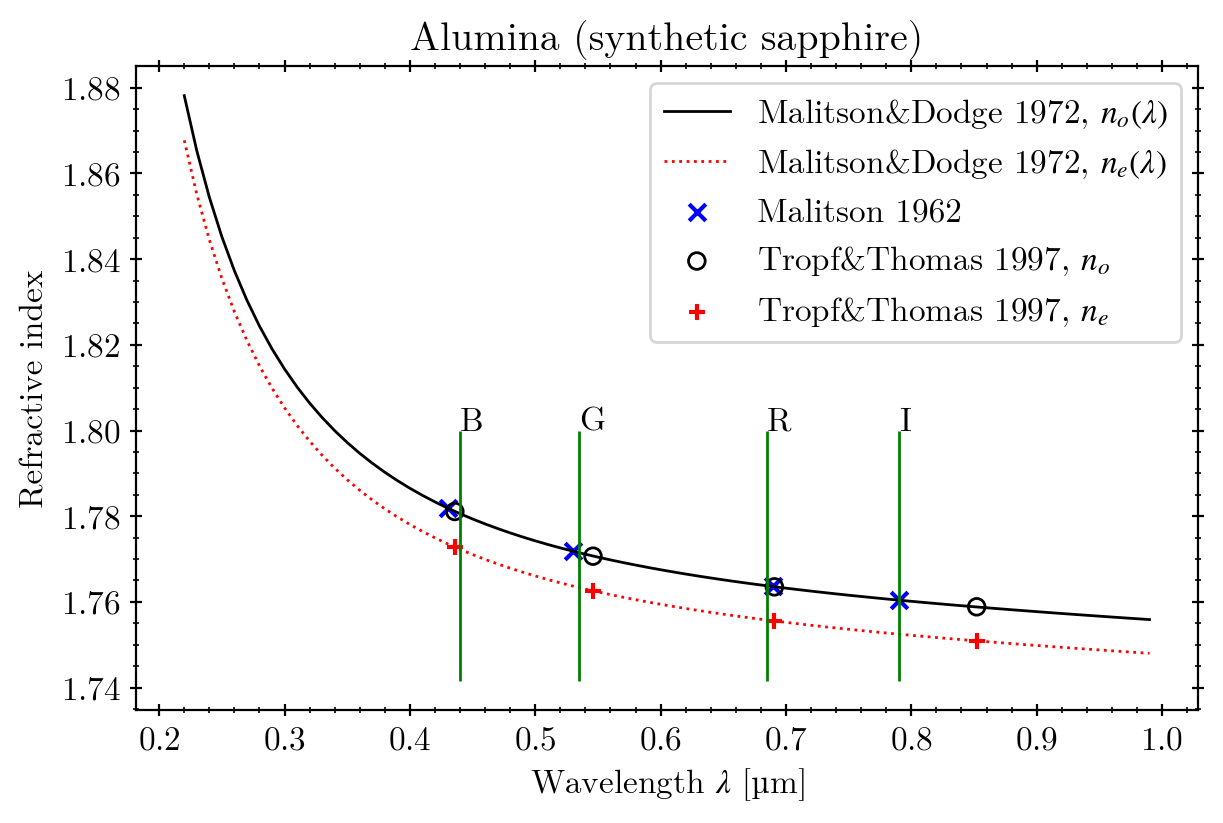

In [3]:
def alumina_dispersion(wlen):
    # From Weber 2002 Handbook sect 1.3.4 (also in Tropf&Thomas 1997 Table II)
    n_o = np.sqrt(1 + wlen**2*(
        1.43134936/(wlen**2 - 0.0726631**2)
        + 0.65054713/(wlen**2 - 0.1193242**2)
        + 5.3414021/(wlen**2 - 18.028251**2)
    ))
    n_e = np.sqrt(1 + wlen**2*(
        1.5039759/(wlen**2 - 0.0740288**2)
        + 0.55069141/(wlen**2 - 0.1216529**2)
        + 6.59273791/(wlen**2 - 20.072248**2)
    ))
    return n_o, n_e

wlens = np.arange(0.22, 1, 0.01)
fig, axs = plt.subplots(1, 1, figsize=(6, 4), layout="constrained", sharex=False, sharey=False, gridspec_kw=None)

nos, nes = alumina_dispersion(wlens)
axs.plot(wlens, nos, "k-", label="Malitson&Dodge 1972, $n_o(λ)$", lw=1)
axs.plot(wlens, nes, "r:", label="Malitson&Dodge 1972, $n_e(λ)$", lw=1)
axs.scatter([0.43, 0.53, 0.69, 0.79], [1.78199, 1.77191, 1.76362, 1.76046], color="b", marker="x", label="Malitson 1962")
axs.scatter([0.43583, 0.54607, 0.69072, 0.85212], [1.78110, 1.77067, 1.76351, 1.75885], color="k", marker="o",
            facecolors="none", label="Tropf&Thomas 1997, $n_o$")
axs.scatter([0.43583, 0.54607, 0.69072, 0.85212], [1.77275, 1.76254, 1.75549, 1.75090], color="r", marker="+",
            label="Tropf&Thomas 1997, $n_e$")

axs.legend()
print(alumina_dispersion(0.43))
print(alumina_dispersion(0.44))
print(alumina_dispersion(0.79))
print(alumina_dispersion(0.54607))  # To compare with Tropf+1997 table (n_e=1.76258)
_filt_wls = [0.44, 0.535, 0.685, 0.790]
axs.vlines(_filt_wls, axs.get_ylim()[0], 1.8, color="g", lw=1)
[axs.text(_wl, 1.8, _filt) for _wl, _filt in zip(_filt_wls, "BGRI")]
axs.set(xlabel="Wavelength $λ$ [µm]", ylabel="Refractive index", title="Alumina (synthetic sapphire)")
plt.savefig("figs/alumina-ref-ind.pdf", dpi=300)
plt.show();

## Alumina fit (Geake & Geake 1990)

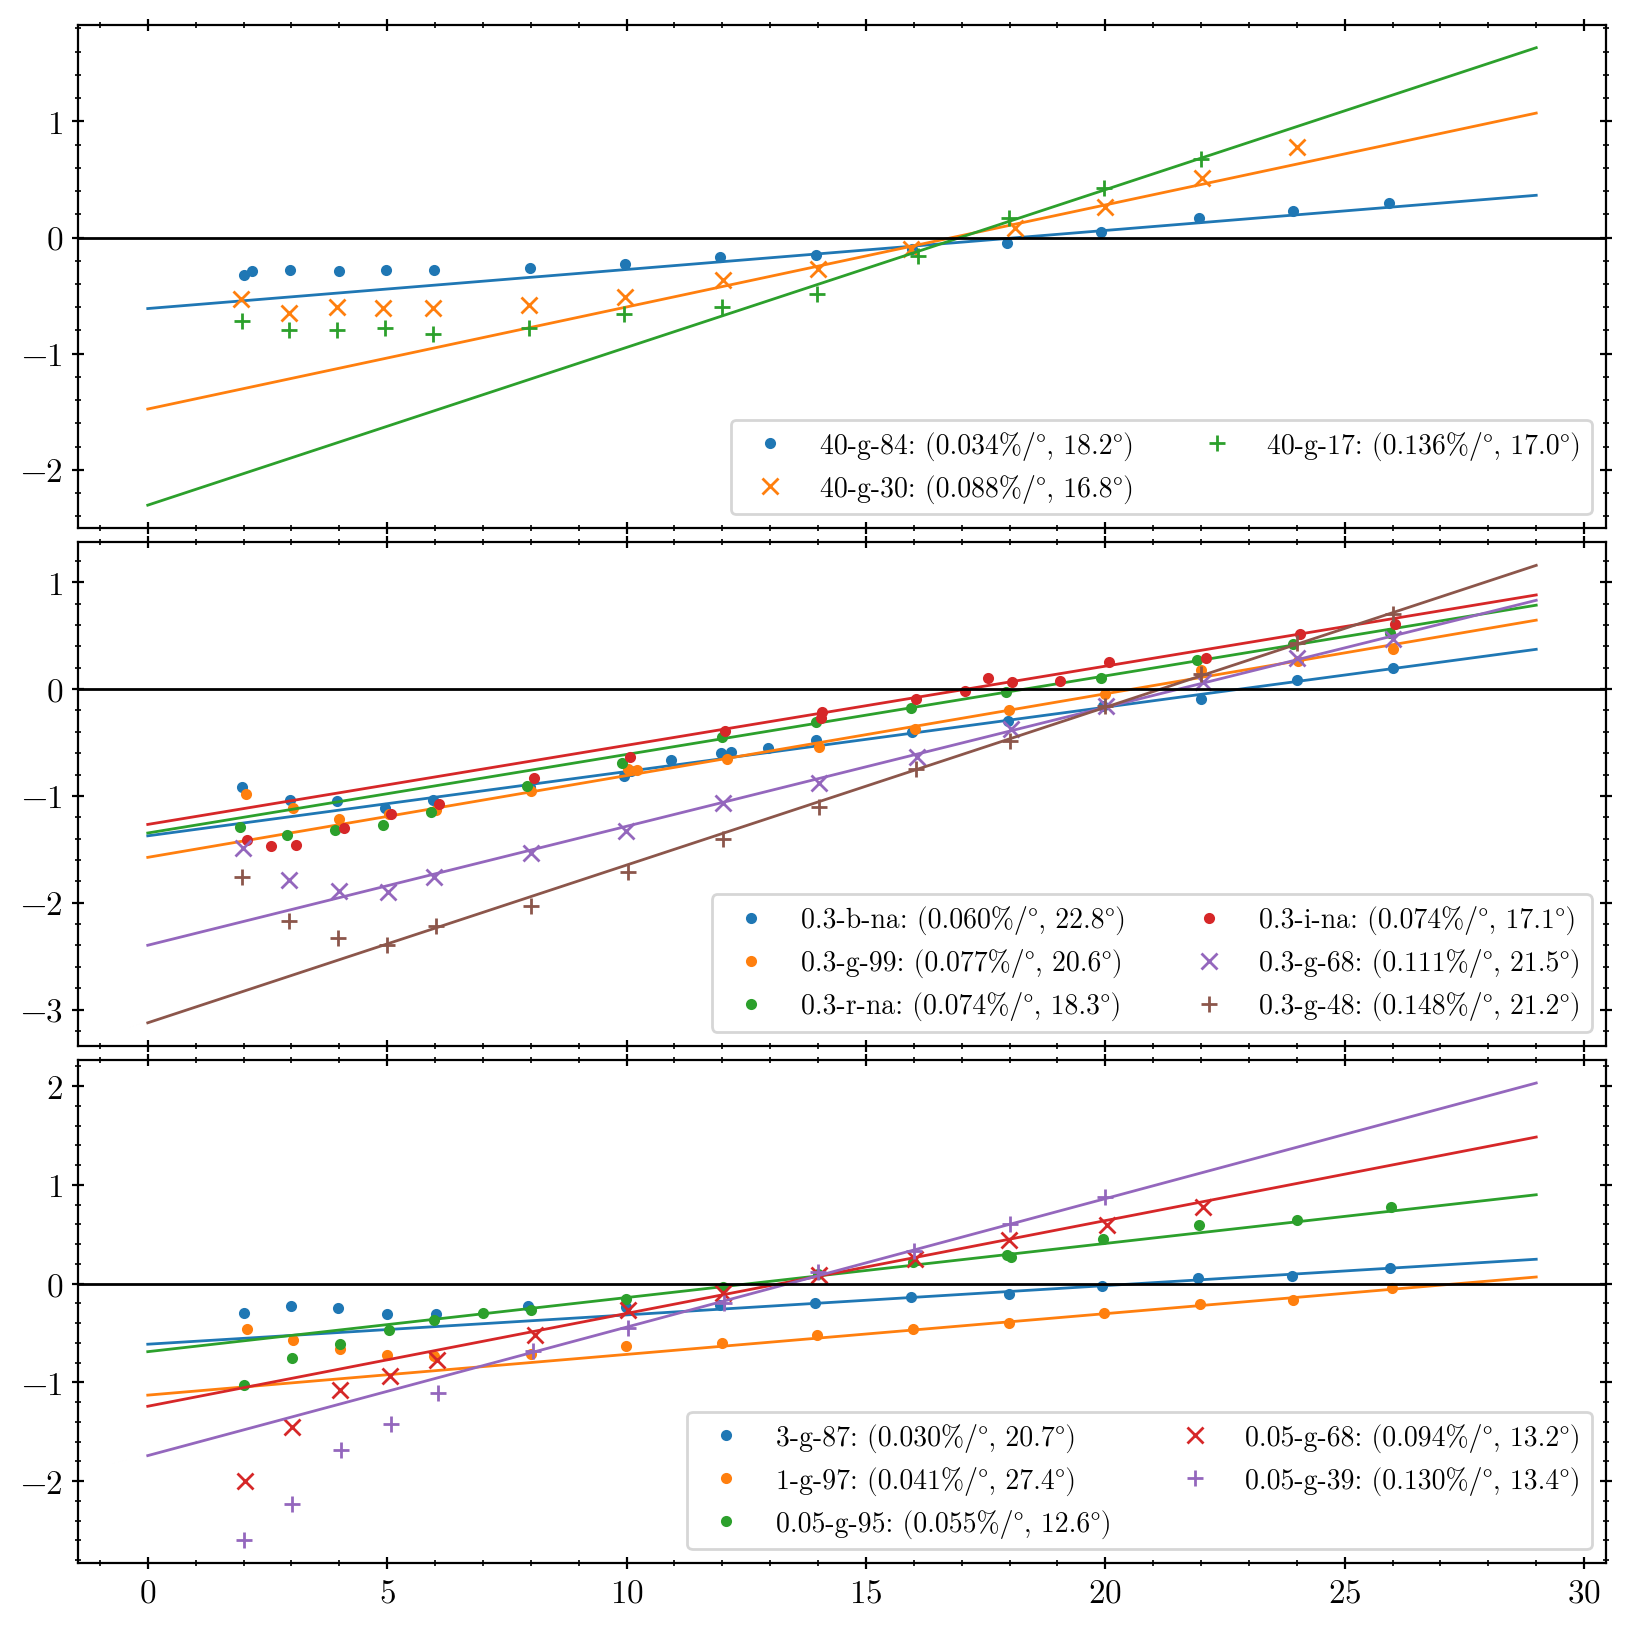

In [4]:
kw_1990 = {
    'Al2O3': dict(marker="."),
    'Al2O3+0.5C': dict(marker="x"),
    'Al2O3+2C':dict(marker="+"),
}
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True, sharey=False, gridspec_kw=None)
aa = np.arange(0, 30)
df_ppc_alum_fit = dict(
    name=[],
#     material=[], size=[],
    size_lambda=[],
#     filter_num=[], filter_name=[], filter_wlen=[],
    albedo=[],
#     Pmin=[], dPmin=[], amin=[], damin=[], a0=[], da0=[],
    a0fit=[], hfit=[])
for name in df_ppc_alum.name.unique():
    _df = df_ppc_alum.loc[(df_ppc_alum["name"]==name) & (df_ppc_alum["alpha"] < 40)].copy()
    _sz = _df["size"].iloc[0]
    _x, _y = _df["alpha"], _df["Pr"]
    _ppc = sbppc.PPCModel("le")
    _ppc.solve_lsq(_x, _y)
    _a0 = _ppc.theta_lsq[1]
    _sep_mask = np.abs(_x - _a0) < np.sort(np.abs(_x - _a0))[6]
    # _sep_mask = (0 <= (_x - _a0)) & ((_x - _a0) <= 10)
    _popt, _ = curve_fit(linf, _x[_sep_mask], _y[_sep_mask], p0=[0.1, -0.1*_a0])
    a0, h = -_popt[1]/_popt[0], _popt[0]
    df_ppc_alum_fit["name"].append(name)
    df_ppc_alum_fit["a0fit"].append(a0)
    df_ppc_alum_fit["albedo"].append(_df["albedo"].iloc[0])
    df_ppc_alum_fit["size_lambda"].append(_df["size_lambda"].iloc[0])
    df_ppc_alum_fit["hfit"].append(h)
    _ax = axs[0] if _sz==40 else axs[1] if _sz==0.3 else axs[2]
    l = _ax.plot(_x, _y, **kw_1990[_df["material"].iloc[0]], ls="", label=f"{name}: ({h:.3f}%/°, {a0:.1f}°)")
    # axr.plot(_x[_sep_mask], _y[_sep_mask] - linf(_x[_sep_mask], *_popt), **kw_1990[_df["material"].iloc[0]], lw=1)
    _ax.plot(aa, linf(aa, *_popt), color=l[0].get_color(), lw=1)
for _ax in axs:
    _ax.axhline(0, color="k", lw=1)
    _ax.legend(loc=4, ncol=2, fontsize=10)
plt.tight_layout(pad=0.1)
plt.show();
df_ppc_alum_fit = pd.DataFrame.from_dict(df_ppc_alum_fit)

## Umov's Law

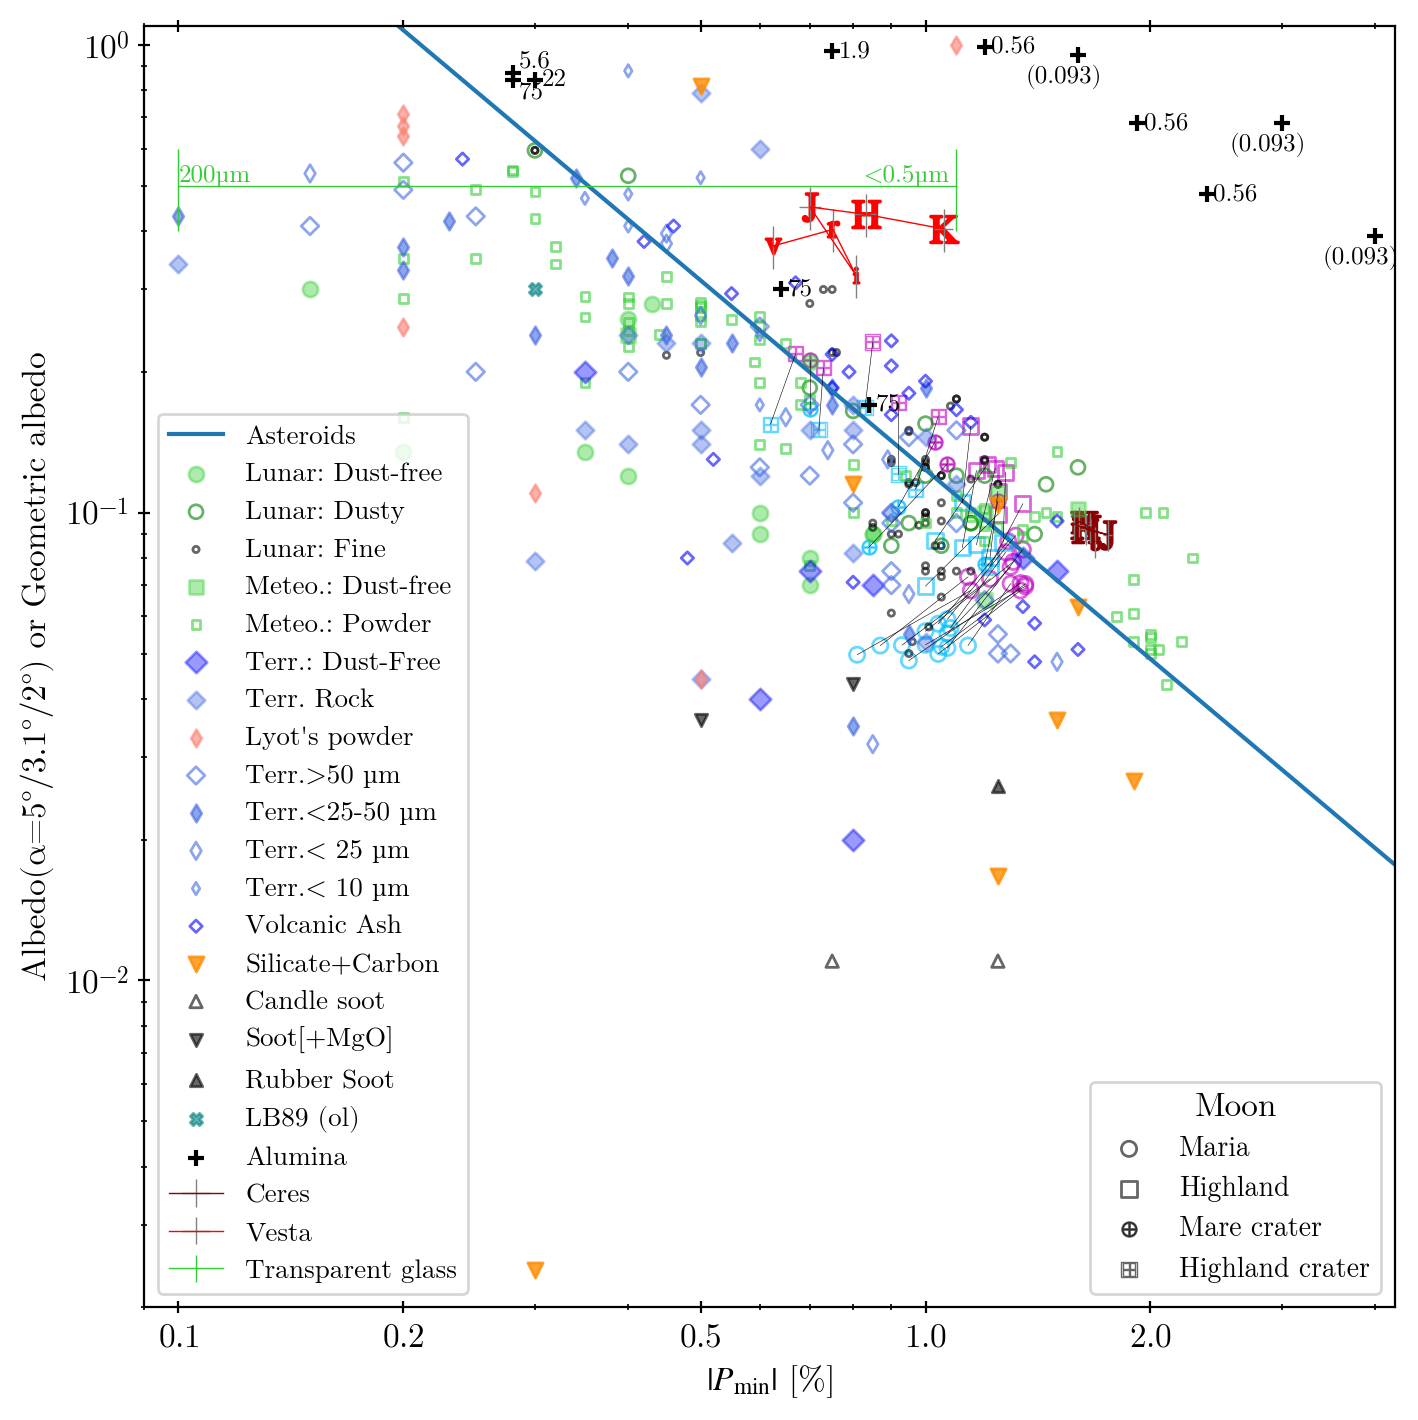

In [5]:
kws_lab = {
    'Lunar Dust-Free':dict(marker="o", s=30, alpha=0.4, color="limegreen", label="Lunar: Dust-free"),
    'Lunar Dusty':dict(marker="o", facecolors="none", s=25, alpha=0.6, color="g", label="Lunar: Dusty"),
    'Lunar Fine':dict(marker="o", facecolors="none", s=5, alpha=0.6, color="k", label="Lunar: Fine"),
    'Met Dust-Free':dict(marker="s", s=25, alpha=0.4, color="limegreen", label="Meteo.: Dust-free"),
    'Met Powder':dict(marker="s", facecolors="none", s=10, alpha=0.6, color="limegreen", label="Meteo.: Powder"),
    'Rock Dust-Free':dict(marker="D", s=30, alpha=0.4, color="blue", label="Terr.: Dust-Free"),
    'Lyot-rock':dict(marker="D", s=20, alpha=0.4, color="royalblue", label="Terr. Rock"),
    'Lyot-powder':dict(marker="d", s=20, alpha=0.6, color="salmon", label="Lyot's powder"),
    'Rock Powder 340':dict(marker="D", facecolors="none", s=20, alpha=0.6, color="royalblue", label="Terr.>50 µm"),
    'Rock Powder 50':dict(marker="d", s=20, alpha=0.6, color="royalblue", label="Terr.<25-50 µm"),
    'Rock Powder 25':dict(marker="d", facecolors="none", s=20, alpha=0.6, color="royalblue", label="Terr.< 25 µm"),
    'Rock Powder 10':dict(marker="d", facecolors="none", s=10, alpha=0.6, color="royalblue", label="Terr.< 10 µm"),
    'Volcanic Ash':dict(marker="D", facecolors="none", s=10, alpha=0.6, color="blue", label="Volcanic Ash"),
    "silica+carbon":dict(marker="v", s=30, alpha=0.8, color="darkorange", label="Silicate+Carbon"),
    "Candle Soot":dict(marker="^", facecolors="none", s=20, alpha=0.6, color="k", label="Candle soot"),
    "Soot":dict(marker="v", s=20, alpha=0.6, color="k", label="Soot[+MgO]"),
    "Rubber Soot":dict(marker="^", s=20, alpha=0.6, color="k", label="Rubber Soot"),
    # "Silica mix 200":dict(marker="1", s=30, alpha=0.6, color="orange", label="Silica mix 200µm"),
    # "Silica mix 2000":dict(marker="2", s=40, alpha=0.6, color="k", label="Silica mix 2mm"),
}
kws_minerals = {
    "1989Icar...78..395L":dict(marker="X", s=20, alpha=0.6, color="teal", label="LB89 (ol)"),
    # "2004JQSRT..88..267S":dict(marker="P", s=20, alpha=0.6, color="teal", label="S04 (ol)"),
    # "2021ApJS..256...17M":dict(marker="x", s=20, alpha=0.6, color="orange", label="M21 (fo)"),
    # "2022A&A...665A..49S":dict(marker="1", s=20, alpha=0.6, color="k", label="Mineral mix (S22)"),
    # "2023Icar..39515492S":dict(marker="3", s=20, alpha=0.6, color="r", label="S23 (ol-FeS)"),
}
kws_lunar = {
    "maria": dict(marker="o", s=30, facecolors="none", alpha=0.6),
    "highland": dict(marker="s",s=30,  facecolors="none", alpha=0.6),
    "mare crater": dict(marker=r"$\oplus$", s=30, linewidths=0.5, alpha=0.6),
    "highland crater": dict(marker=r"$\boxplus$", s=30, facecolors="none", linewidths=0.5, alpha=0.6),
}
kws = dict(
    Ceres=dict(color="darkred"),
    Vesta=dict(color="r")
)

fig, axap = plt.subplots(1, 1, figsize=(7, 7), sharex=False, sharey=False, gridspec_kw=None)
axmoon = axap.twinx()
axmoon.axis("off")

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=100 if row.filt in "JHK" else 30)
    axap.scatter(-row["Pmin"], row["alb"], **mk, **kws[row.object])

for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    axap.errorbar(-_df["Pmin"], _df["alb"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                    xerr=(_df["DPmin"], _df["dPmin"]), yerr=_df["dalb"], label=objname)
    # dPmin and DPmin must be swapped because x axis is flipped.


# General trend from Lupishko 2018
_hvals = np.array([1.e-2, 1])
_pmins = np.array([1.e-1, 5])
_a_pmins = 10**(-1.344*np.log10(_pmins) - 0.908)
_a_hvals = 10**(-0.989*np.log10(_hvals) - 1.719)
axap.plot(_pmins, _a_pmins, label="Asteroids")


# Lunar observation from Shkuratov+1992
for _id in df_lunar.id.unique():
    _rowb = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.42)]
    _rowr = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.65)]
    axap.scatter(_rowb["P10.5"], _rowb["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
    axap.scatter(_rowr["P10.5"], _rowr["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="m")
    axap.plot((_rowr["P10.5"], _rowb["P10.5"]), (_rowr["alb3.1"]/100, _rowb["alb3.1"]/100), "k-", lw=0.2)
for typ, kw in kws_lunar.items():
    axmoon.scatter(np.nan, np.nan, **kw, color="k", label=typ.capitalize())

for k, kw in kws_lab.items():
    _df = df_lab.loc[df_lab["category"]==k].copy()
    mask = _df["dPmin"] > 0.3
    axap.scatter(np.abs(_df["Pmin"][~mask]), _df["_alb"][~mask], **kw)

for k, kw in kws_minerals.items():
    _df = df_lab.loc[(df_lab["ref"]==k) & (df_lab["category"].isin(["Mineral", "Mineral mix", "Silica mix 20"]))].copy()
    if np.all(np.isnan(_df["_alb"])):
        continue
    mask = _df["dPmin"] > 1
    axap.scatter(np.abs(_df["Pmin"][~mask]), _df["_alb"][~mask], **kw)

# Alumina from Geake&Geake 1990
axap.scatter(np.abs(df_alum_all["Pmin"]), df_alum_all["albedo"]/100, marker="+", color="k", label="Alumina")

for _, row in df_alum_all.iterrows():
    sl = row["size_lambda"]
    sl_str = f"{sl}" if sl < 10 else f"{sl:.0f}"
    _y = row["albedo"]/100
    _dx = 1.02
    if sl == 75 and _y > 0.5:
        _y -= 0.05
    elif sl == 5.6:
        _y += 0.05
    elif sl == 0.093:
        sl_str = f"({sl_str})"
        _y *= 0.9
        _dx = 0.85
    if not np.isnan(_y):
        axap.text(np.abs(row["Pmin"])*_dx, _y, sl_str, fontsize=9, va="center")

# Shkuratov glass
axap.errorbar(np.abs(shkglass["Pmin"]), [0.5, 0.5], yerr=0.1, color="limegreen", lw=0.5, elinewidth=0.5, label="Transparent glass")
axap.text(np.abs(shkglass["Pmin"]).max()*0.75, 0.51, "<0.5µm", fontsize=9, color="limegreen", ha="left")
axap.text(np.abs(shkglass["Pmin"]).min()*1.25, 0.51, "200µm", fontsize=9, color="limegreen", ha="right")

axap.set(xlabel="$|P_\mathrm{min}|$ [%]", ylabel="Albedo(α=5°/3.1°/2°) or Geometric albedo",
           yscale='log', xscale='log',
         xlim=(0.09, 4.25), ylim=(0.002, 1.1)
        )
axap.legend(loc=3, fontsize=9.8, ncol=1)
axmoon.legend(loc="lower right", fontsize=10, title="Moon")

# Show some more ticks on x-axis
labels = [item.get_text() for item in axap.get_xticklabels()]
axap.set_xticks([0.1, 0.2, 0.5, 1, 2])
axap.xaxis.set_major_formatter(ScalarFormatter())


plt.tight_layout(pad=0.1)
plt.savefig("figs/pmin-albedo.pdf", dpi=300)
plt.show();

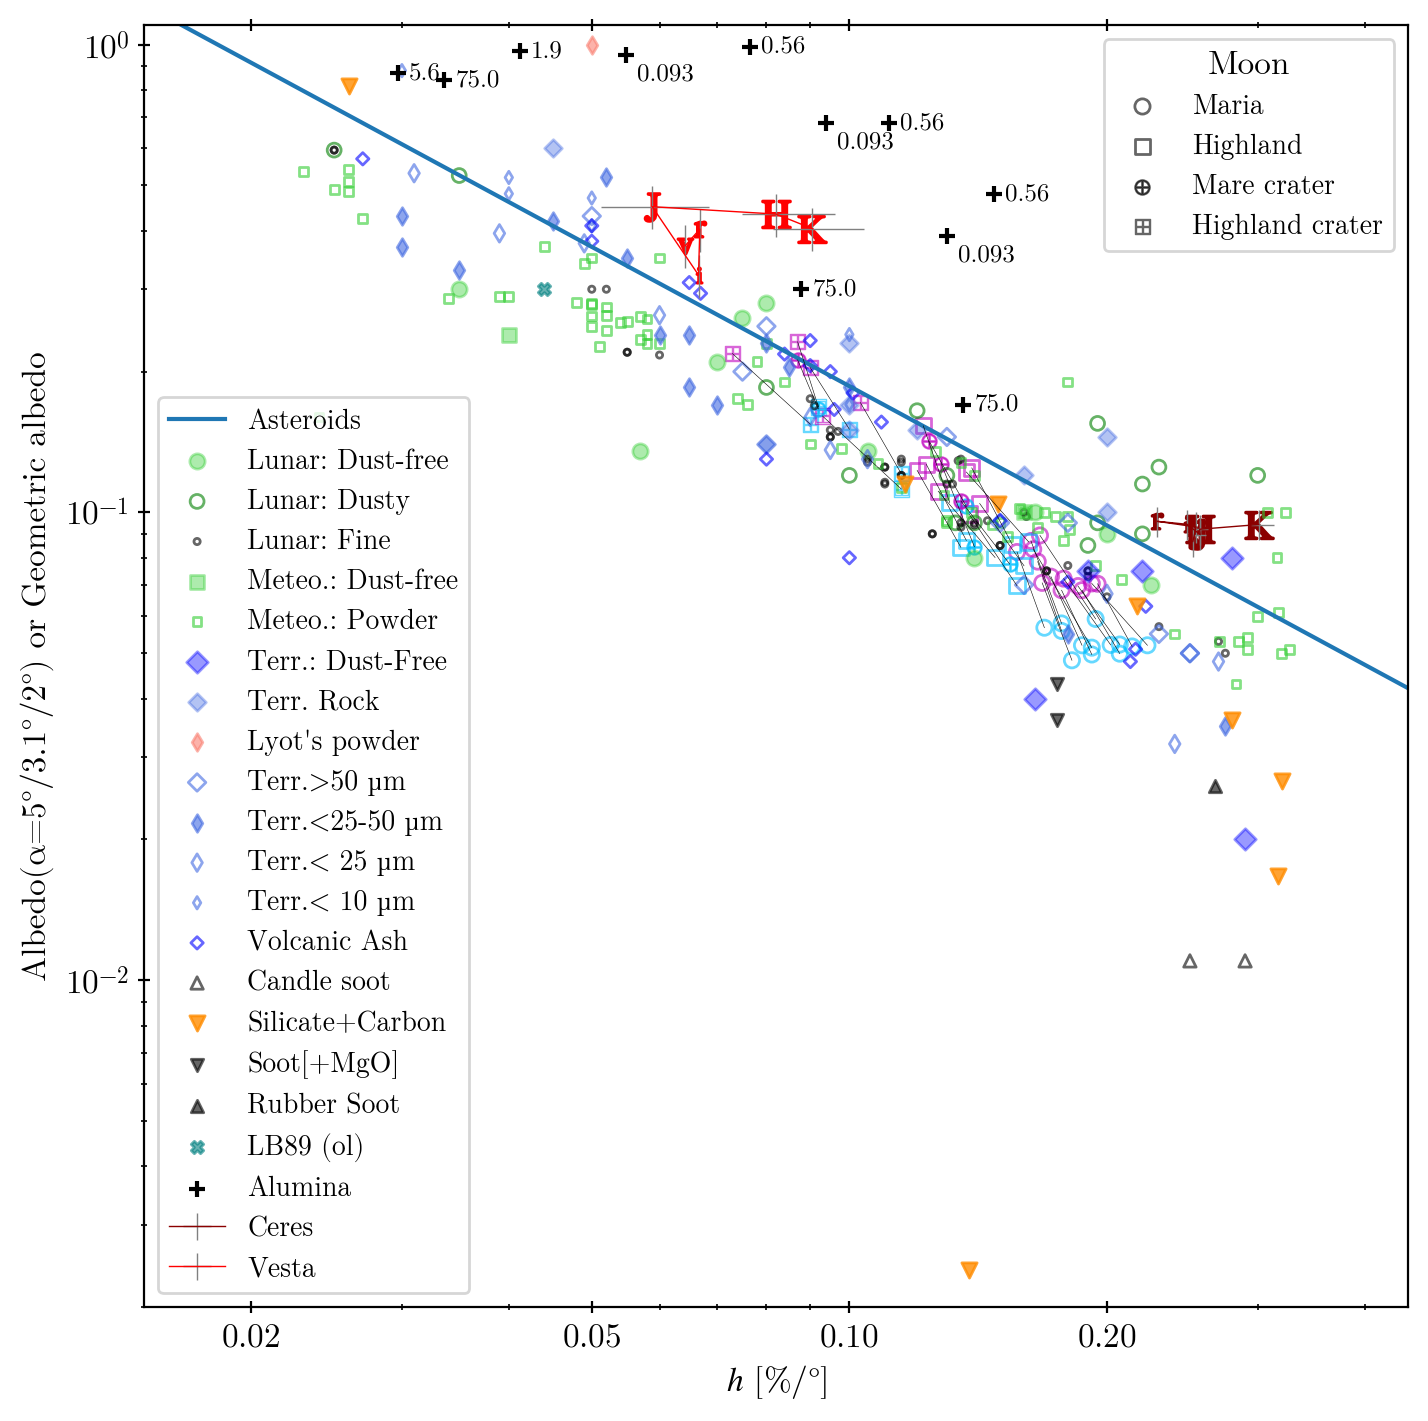

In [6]:
kws_lab = {
    'Lunar Dust-Free':dict(marker="o", s=30, alpha=0.4, color="limegreen", label="Lunar: Dust-free"),
    'Lunar Dusty':dict(marker="o", facecolors="none", s=25, alpha=0.6, color="g", label="Lunar: Dusty"),
    'Lunar Fine':dict(marker="o", facecolors="none", s=5, alpha=0.6, color="k", label="Lunar: Fine"),
    'Met Dust-Free':dict(marker="s", s=25, alpha=0.4, color="limegreen", label="Meteo.: Dust-free"),
    'Met Powder':dict(marker="s", facecolors="none", s=10, alpha=0.6, color="limegreen", label="Meteo.: Powder"),
    'Rock Dust-Free':dict(marker="D", s=30, alpha=0.4, color="blue", label="Terr.: Dust-Free"),
    'Lyot-rock':dict(marker="D", s=20, alpha=0.4, color="royalblue", label="Terr. Rock"),
    'Lyot-lava powder':dict(marker="D", s=20, alpha=0.6, color="salmon", label="Terr. Lava powder"),
    'Lyot-powder':dict(marker="d", s=20, alpha=0.6, color="salmon", label="Lyot's powder"),
    'Rock Powder 340':dict(marker="D", facecolors="none", s=20, alpha=0.6, color="royalblue", label="Terr.>50 µm"),
    'Rock Powder 50':dict(marker="d", s=20, alpha=0.6, color="royalblue", label="Terr.<25-50 µm"),
    'Rock Powder 25':dict(marker="d", facecolors="none", s=20, alpha=0.6, color="royalblue", label="Terr.< 25 µm"),
    'Rock Powder 10':dict(marker="d", facecolors="none", s=10, alpha=0.6, color="royalblue", label="Terr.< 10 µm"),
    'Volcanic Ash':dict(marker="D", facecolors="none", s=10, alpha=0.6, color="blue", label="Volcanic Ash"),
    "Candle Soot":dict(marker="^", facecolors="none", s=20, alpha=0.6, color="k", label="Candle soot"),
    "silica+carbon":dict(marker="v", s=30, alpha=0.8, color="darkorange", label="Silicate+Carbon"),
    # "Silica mix 200":dict(marker="1", s=30, alpha=0.6, color="orange", label="Silica mix 200µm"),
    # "Silica mix 2000":dict(marker="2", s=40, alpha=0.6, color="k", label="Silica mix 2mm"),
    "Soot":dict(marker="v", s=20, alpha=0.6, color="k", label="Soot[+MgO]"),
    "Rubber Soot":dict(marker="^", s=20, alpha=0.6, color="k", label="Rubber Soot"),
}

fig, axah = plt.subplots(1, 1, figsize=(7, 7), sharex=False, sharey=False, gridspec_kw=None)
axmoon = axah.twinx()
axmoon.axis("off")

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=100 if row.filt in "JHK" else 30)
    axah.scatter(row["h"], row["alb"], **mk, **kws[row.object])

for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    axah.errorbar(_df["h"], _df["alb"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                    xerr=(_df["dh"], _df["Dh"]), yerr=_df["dalb"], label=objname)


# General trend from Lupishko 2018
_hvals = np.array([1.e-6, 1])
_pmins = np.array([1.e-6, 5])
_a_pmins = 10**(-1.344*np.log10(_pmins) - 0.908)
_a_hvals = 10**(-0.989*np.log10(_hvals) - 1.719)
axah.plot(_hvals, _a_hvals, label="Asteroids")


# Lunar observation from Shkuratov+1992
for _id in df_lunar.id.unique():
    _rowb = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.42)]
    _rowr = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.65)]
    axah.scatter(_rowb["h"], _rowb["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
    axah.scatter(_rowr["h"], _rowr["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="m")
    axah.plot((_rowr["h"], _rowb["h"]), (_rowr["alb3.1"]/100, _rowb["alb3.1"]/100), "k-", lw=0.2)
for typ, kw in kws_lunar.items():
    axmoon.scatter(np.nan, np.nan, **kw, color="k", label=typ.capitalize())

for k, kw in kws_lab.items():
    _df = df_lab.loc[df_lab["category"]==k].copy()
    mask = _df["dh"] > 0.02
    if np.all(np.isnan(_df["h"])):
        continue
    axah.scatter(np.abs(_df["h"][~mask]), _df["_alb"][~mask], **kw)
    # axah.errorbar(np.abs(_df["h"]), _df["_alb"], xerr=_df["dh"], elinewidth=0.5, color="gray", ls="")

for k, kw in kws_minerals.items():
    _df = df_lab.loc[(df_lab["ref"]==k) & (df_lab["category"].isin(["Mineral", "Mineral mix"]))].copy()
    if np.all(np.isnan(_df["_alb"])):
        continue
    mask = _df["dh"] > 0.02
    axah.scatter(np.abs(_df["h"][~mask]), _df["_alb"][~mask], **kw)


# Alumina from Geake&Geake 1990
axah.scatter(np.abs(df_ppc_alum_fit["hfit"]), df_ppc_alum_fit["albedo"]/100, marker="+", color ="k", label="Alumina")
for _, row in df_ppc_alum_fit.iterrows():
    sl = row["size_lambda"]
    _y = row["albedo"]/100
    if sl == 0.093:
        _y *= 0.91
    if not np.isnan(_y):
        axah.text(row["hfit"]*1.03, _y, sl, fontsize=9, va="center")

# forsterite from Munoz+2021

# axah.legend(loc=3, fontsize=10, ncol=1, bbox_to_anchor=(1, 0))
axah.legend(loc=3, fontsize=10, ncol=1)
axmoon.legend(loc=1, fontsize=10, title="Moon")
axah.set(xlabel="$h$ [%/°]", ylabel="Albedo(α=5°/3.1°/2°) or Geometric albedo",
           yscale='log', xscale='log', xlim=(0.015, 0.45), ylim=(0.002, 1.1))

# Show some more ticks on x-axis
labels = [item.get_text() for item in axap.get_xticklabels()]
axah.set_xticks([0.02, 0.05, 0.1, 0.2])
axah.xaxis.set_major_formatter(ScalarFormatter())

plt.tight_layout(pad=0.1)
plt.savefig("figs/h-albedo.pdf", dpi=300)
plt.show();

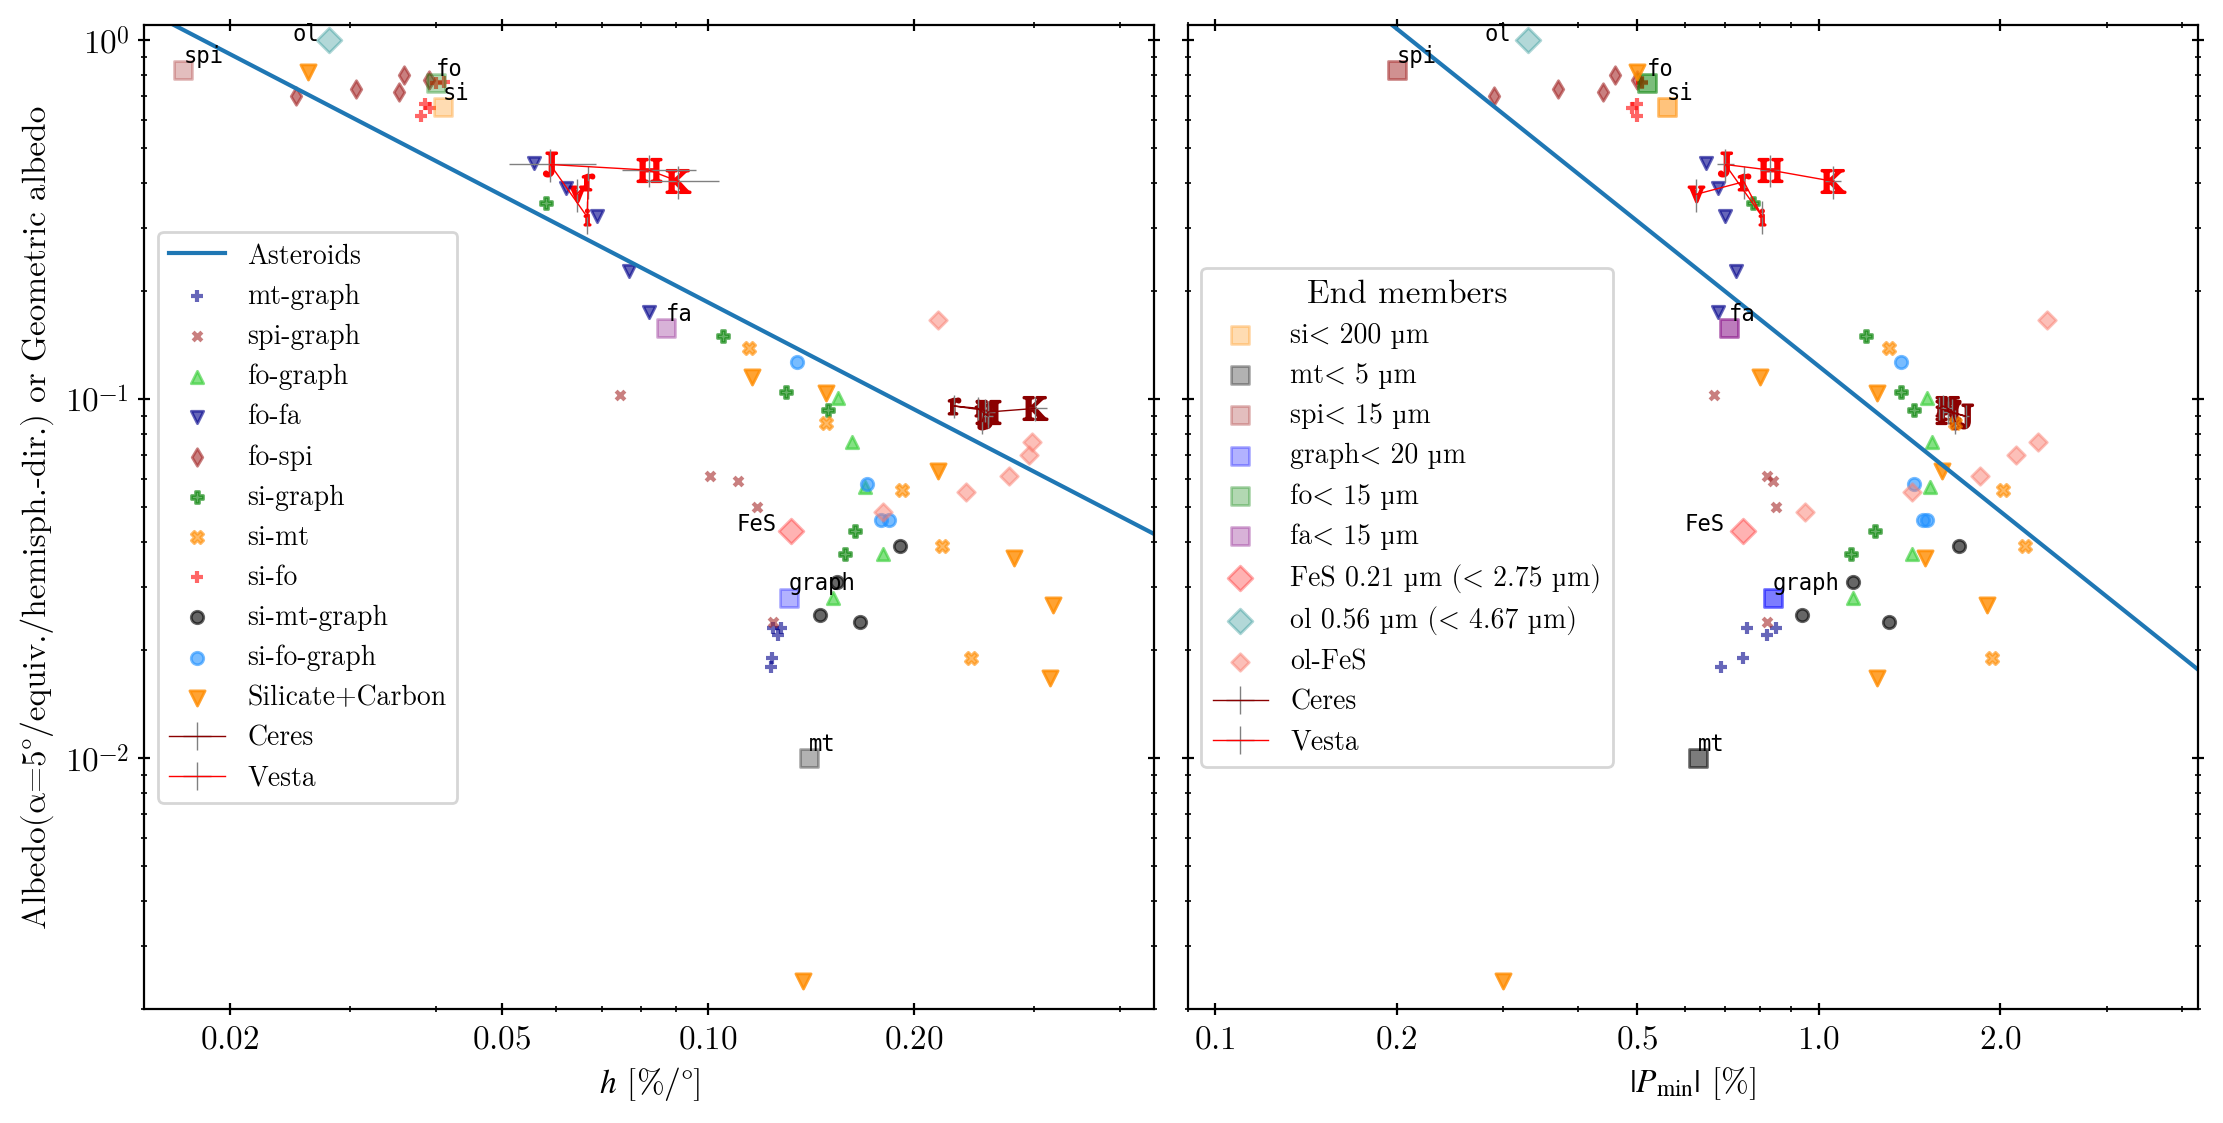

In [7]:
kws_spa22_end = {
    "si":dict(marker="s", s=40, alpha=0.3, color="darkorange", label="si< 200 µm"),
    "mt":dict(marker="s", s=40, alpha=0.3, color="k", label="mt< 5 µm"),
    "spi":dict(marker="s", s=40, alpha=0.3, color="brown", label="spi< 15 µm"),
    "graph":dict(marker="s", s=40, alpha=0.3, color="b", label="graph< 20 µm"),
    "fo":dict(marker="s", s=40, alpha=0.3, color="g", label="fo< 15 µm"),
    "fa":dict(marker="s", s=40, alpha=0.3, color="purple", label="fa< 15 µm"),
}
kws_spa22_mix = {
    "mt-graph":dict(marker="+", s=20, alpha=0.6, color="darkblue"),
    "spi-graph":dict(marker="x", s=10, alpha=0.6, color="brown"),
    "fo-graph":dict(marker="^", s=20, alpha=0.6, color="limegreen"),
    "fo-fa":dict(marker="v", s=20, alpha=0.6, color="darkblue"),
    "fo-spi":dict(marker="d", s=20, alpha=0.6, color="brown"),
    "si-graph":dict(marker="P", s=20, alpha=0.6, color="g"),
    "si-mt":dict(marker="X", s=20, alpha=0.6, color="darkorange"),
    "si-fo":dict(marker="+", s=20, alpha=0.6, color="r"),
    "si-mt-graph":dict(marker="o", s=20, alpha=0.6, color="k"),
    "si-fo-graph":dict(marker="o", s=20, alpha=0.6, color="dodgerblue"),
}


fig, axs = plt.subplots(1, 2, figsize=(11, 5.5), layout="constrained", gridspec_kw=None, sharex=False, sharey=True)

axah, axap = axs

axap.plot(_pmins, _a_pmins)
axah.plot(_hvals, _a_hvals, label="Asteroids")

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=70 if row.filt in "JHK" else 30)
    axah.scatter(row["h"], row["alb"], **mk, **kws[row.object])
    axap.scatter(np.abs(row["Pmin"]), row["alb"],**mk, **kws[row.object])

for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    axah.errorbar(_df["h"], _df["alb"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                    xerr=(_df["dh"], _df["Dh"]), yerr=_df["dalb"], label=objname)
    axap.errorbar(-_df["Pmin"], _df["alb"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                    xerr=(_df["DPmin"], _df["dPmin"]), yerr=_df["dalb"], label=objname)


# Spadaccia+2022 MIX
for typ, _kw in kws_spa22_mix.items():
    if "dust-free" in typ.lower():
        continue
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    axah.scatter([None], [None], **kw, label=typ)
    for i, _row in _df.iterrows():
        axah.scatter(_row["h"], _row["_alb"], **kw)
        axap.scatter(np.abs(_row["Pmin"]), _row["_alb"], **kw)

# Spadaccia+2022 ENDMEMBERS
for typ, _kw in kws_spa22_end.items():
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    axap.scatter(np.abs(_df["Pmin"]), _df["_alb"], **kw)
    kw.pop("label")
    for i, _row in _df.iterrows():
        axah.scatter(_row["h"], _row["_alb"], **kw)
        axap.scatter(np.abs(_row["Pmin"]), _row["_alb"], **kw)
        axah.text(_row["h"], _row["_alb"]*1.05, typ, fontsize=8, fontfamily="monospace")
        axap.text(np.abs(_row["Pmin"]), _row["_alb"]*1.05, typ, fontsize=8, fontfamily="monospace")

# SultanaR+2023
for _, row in df_sul23.iterrows():
    marker = "s" if row["sample"] in ["Ol", "FeS"] else "D"
    if row["sample"] == "Ol":
        kw = dict(marker="D", color="teal", s=40, alpha=0.3, label="ol 0.56 µm (< 4.67 µm)")
        axah.text(row["h"]/1.13, row["_alb"], "ol", fontsize=8, fontfamily="monospace")
        axap.text(np.abs(row["Pmin"])/1.18, row["_alb"], "ol", fontsize=8, fontfamily="monospace")
    elif row["sample"] == "FeS":
        kw = dict(marker="D", color="r", s=40, alpha=0.3, label="FeS 0.21 µm (< 2.75 µm)")
        axah.text(row["h"]/1.2, row["_alb"], "FeS", fontsize=8, fontfamily="monospace")
        axap.text(np.abs(row["Pmin"])/1.25, row["_alb"], "FeS", fontsize=8, fontfamily="monospace")
    else:
        kw = dict(marker="D", color="salmon", s=20, alpha=0.5, label=None)
    axap.scatter(np.abs(row["Pmin"]), row["_alb"], **kw)
    kw.pop("label")
    axah.scatter(row["h"], row["_alb"], **kw)
axap.scatter([None], [None], marker="D", color="salmon", s=20, alpha=0.5, label="ol-FeS")

for k, kw in kws_lab.items():
    if k != "silica+carbon":
        continue
    _df = df_lab.loc[df_lab["category"]==k].copy()
    mask = _df["dh"] > 0.02
    axah.scatter(np.abs(_df["h"][~mask]), _df["_alb"][~mask], **kw)
    _kw = kw.copy()
    _kw.pop("label")
    axap.scatter(np.abs(_df["Pmin"][~mask]), _df["_alb"][~mask], **_kw)
    # axah.errorbar(np.abs(_df["h"]), _df["_alb"], xerr=_df["dh"], elinewidth=0.5, color="gray", ls="")

# Alumina from Geake&Geake 1990
# axah.scatter(np.abs(df_ppc_alum_fit["hfit"]), df_ppc_alum_fit["albedo"]/100, marker="+", color="k", label="Alumina")
# axap.scatter(np.abs(df_alum_all["Pmin"]), df_alum_all["albedo"]/100, marker="+", color="k")

axah.set(xlabel="$h$ [%/°]", ylabel="Albedo(α=5°/equiv./hemisph.-dir.) or Geometric albedo",
           yscale='log', xscale='log', xlim=(0.015, 0.45), ylim=(0.002, 1.1))
axah.legend(loc=6, fontsize=10)
axap.set(xlabel="$|P_\mathrm{min}|$ [%]",
         # ylabel="Albedo(equiv./hemisph.-dir.) or Geometric albedo",
           yscale='log', xscale='log', xlim=(0.09, 4.25), ylim=(0.002, 1.1))
axap.legend(loc=6, fontsize=10, title="End members")
# Show some more ticks on x-axis
labels = [item.get_text() for item in axap.get_xticklabels()]
axah.set_xticks([0.02, 0.05, 0.1, 0.2])
axap.set_xticks([0.1, 0.2, 0.5, 1, 2])
axah.xaxis.set_major_formatter(ScalarFormatter())
axap.xaxis.set_major_formatter(ScalarFormatter())

plt.savefig("figs/umov-minerals.pdf", dpi=300)

plt.show();

## Albedo-α0 Space

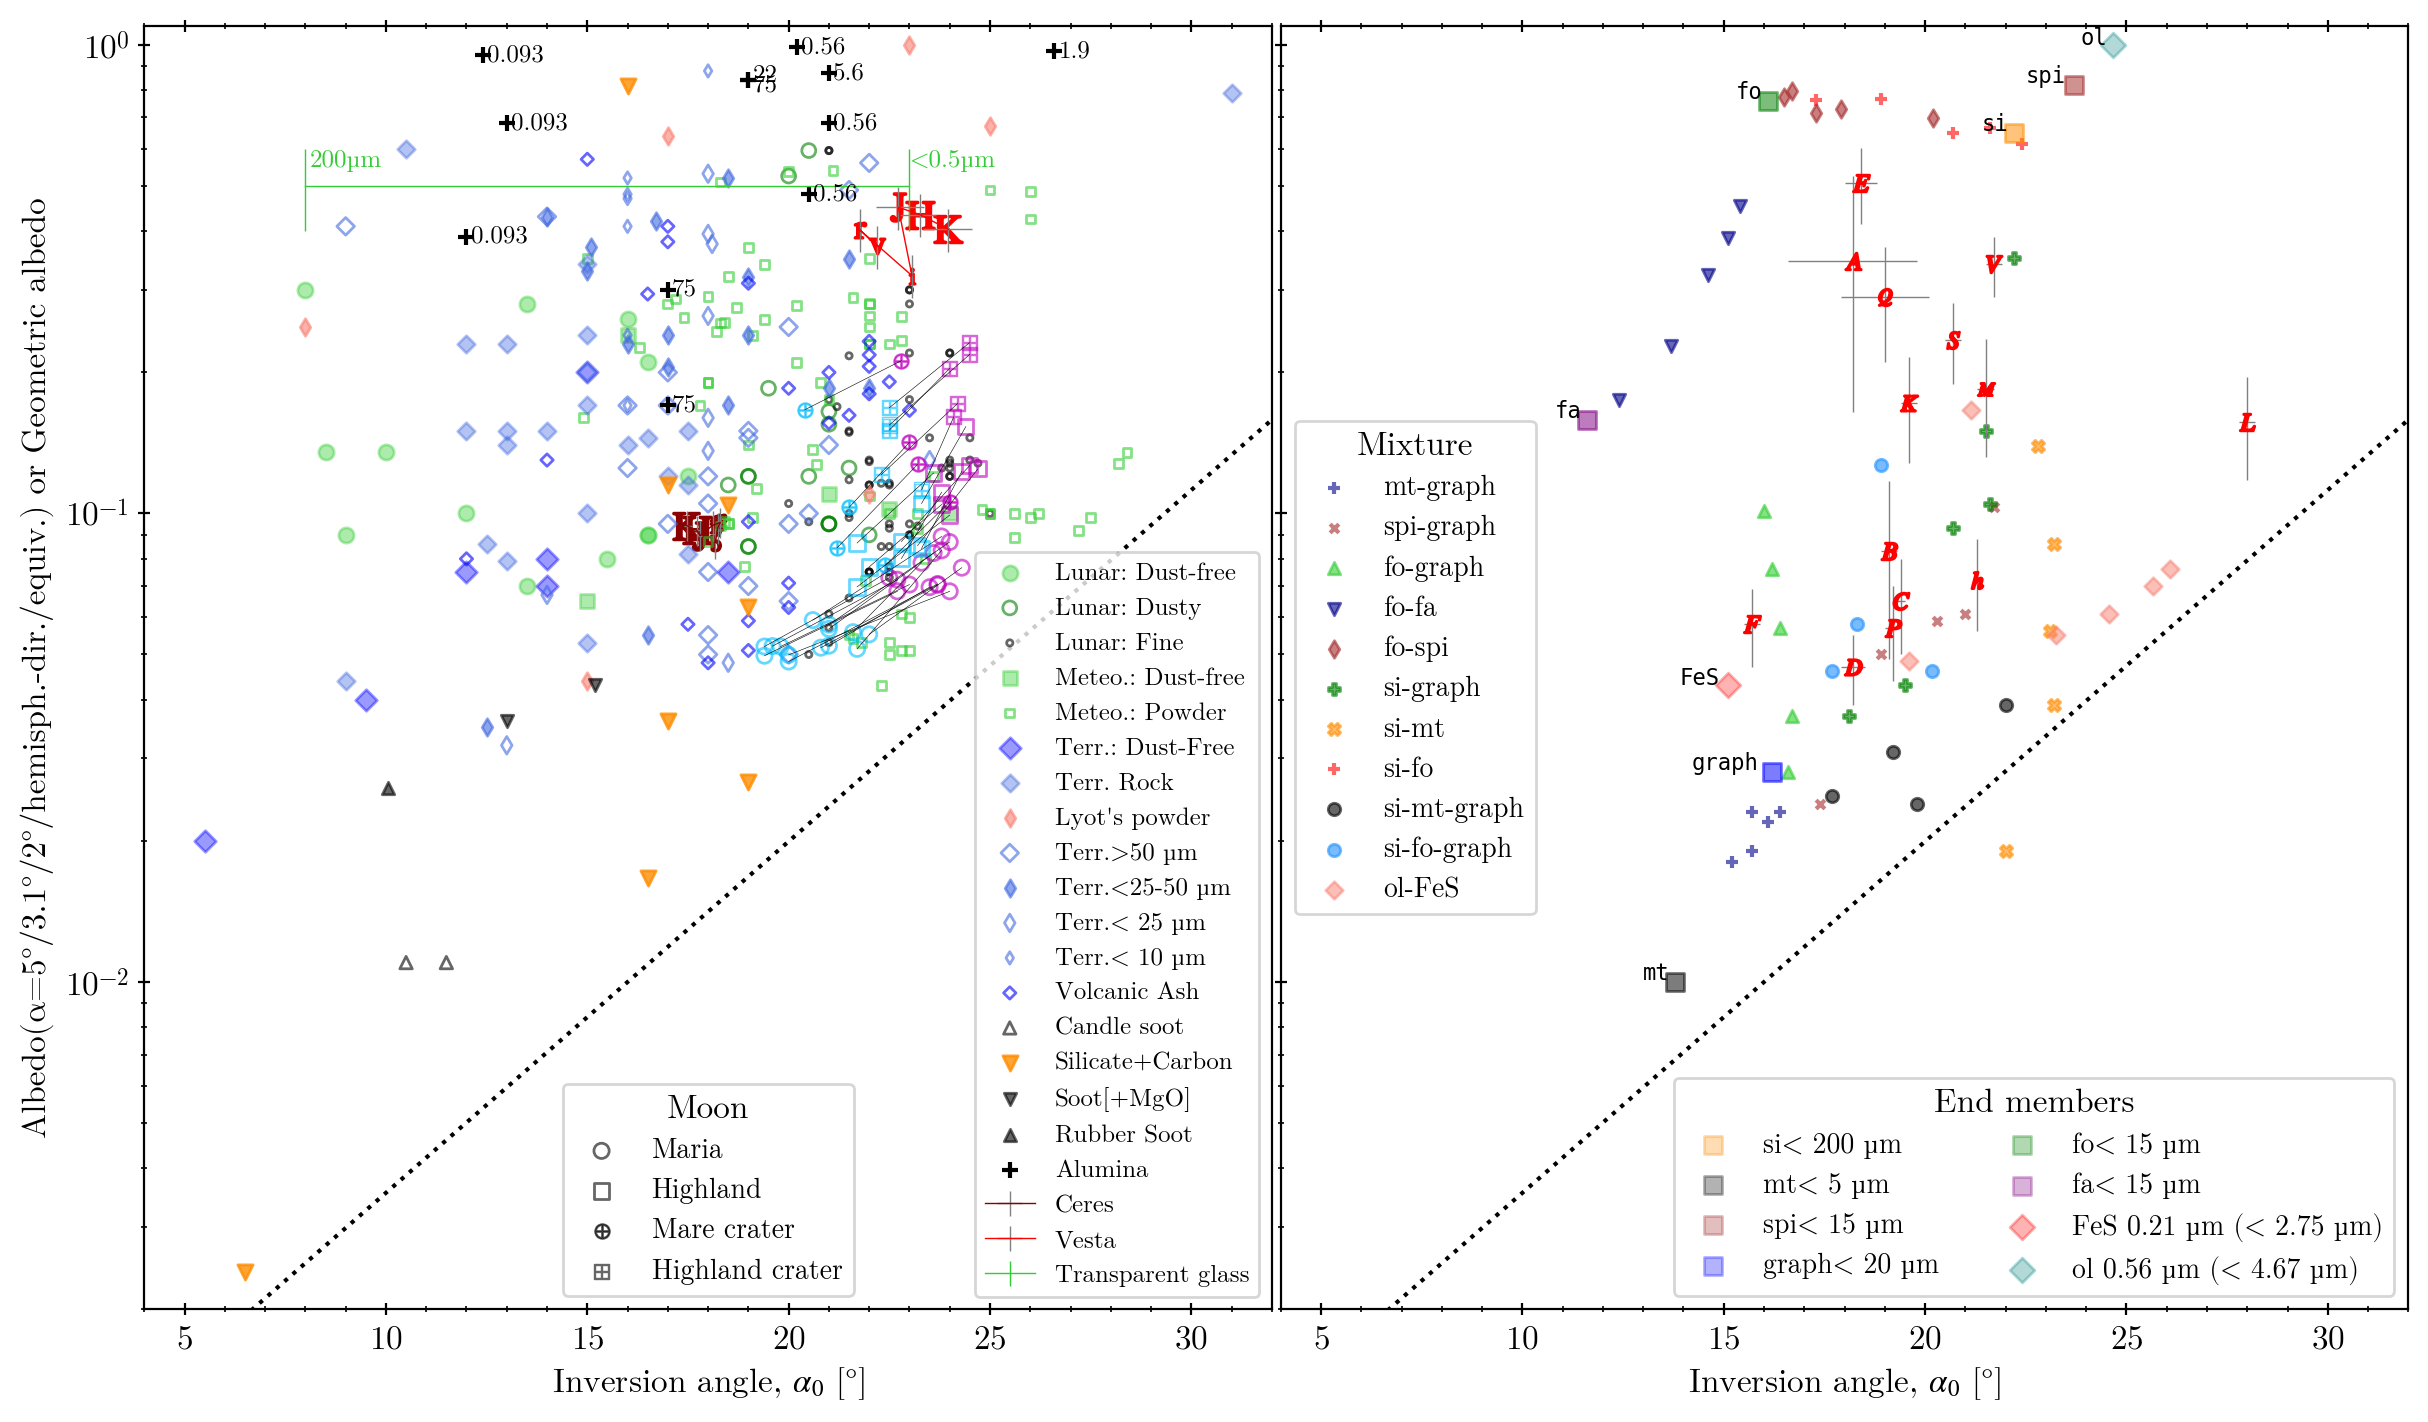

In [8]:
kws_lab = {
    'Lunar Dust-Free':dict(marker="o", s=30, alpha=0.4, color="limegreen", label="Lunar: Dust-free"),
    'Lunar Dusty':dict(marker="o", facecolors="none", s=25, alpha=0.6, color="g", label="Lunar: Dusty"),
    'Lunar Fine':dict(marker="o", facecolors="none", s=5, alpha=0.6, color="k", label="Lunar: Fine"),
    'Met Dust-Free':dict(marker="s", s=25, alpha=0.4, color="limegreen", label="Meteo.: Dust-free"),
    'Met Powder':dict(marker="s", facecolors="none", s=10, alpha=0.6, color="limegreen", label="Meteo.: Powder"),
    'Rock Dust-Free':dict(marker="D", s=30, alpha=0.4, color="blue", label="Terr.: Dust-Free"),
    'Lyot-rock':dict(marker="D", s=20, alpha=0.4, color="royalblue", label="Terr. Rock"),
    'Lyot-powder':dict(marker="d", s=20, alpha=0.6, color="salmon", label="Lyot's powder"),
    'Rock Powder 340':dict(marker="D", facecolors="none", s=20, alpha=0.6, color="royalblue", label="Terr.>50 µm"),
    'Rock Powder 50':dict(marker="d", s=20, alpha=0.6, color="royalblue", label="Terr.<25-50 µm"),
    'Rock Powder 25':dict(marker="d", facecolors="none", s=20, alpha=0.6, color="royalblue", label="Terr.< 25 µm"),
    'Rock Powder 10':dict(marker="d", facecolors="none", s=10, alpha=0.6, color="royalblue", label="Terr.< 10 µm"),
    'Volcanic Ash':dict(marker="D", facecolors="none", s=10, alpha=0.6, color="blue", label="Volcanic Ash"),
    "Candle Soot":dict(marker="^", facecolors="none", s=20, alpha=0.6, color="k", label="Candle soot"),
    "silica+carbon":dict(marker="v", s=30, alpha=0.8, color="darkorange", label="Silicate+Carbon"),
    # "Silica mix 200":dict(marker="1", s=30, alpha=0.6, color="orange", label="Silica mix 200µm"),
    # "Silica mix 2000":dict(marker="2", s=40, alpha=0.6, color="k", label="Silica mix 2mm"),
    "Soot":dict(marker="v", s=20, alpha=0.6, color="k", label="Soot[+MgO]"),
    "Rubber Soot":dict(marker="^", s=20, alpha=0.6, color="k", label="Rubber Soot"),
}
kws_lunar = {
    "maria": dict(marker="o", s=30, facecolors="none", alpha=0.6),
    "highland": dict(marker="s",s=30,  facecolors="none", alpha=0.6),
    "mare crater": dict(marker=r"$\oplus$", s=30, linewidths=0.5, alpha=0.6),
    "highland crater": dict(marker=r"$\boxplus$", s=30, facecolors="none", linewidths=0.5, alpha=0.6),
}
kws_spa22_end = {
    "si":dict(marker="s", s=40, alpha=0.3, color="darkorange", label="si< 200 µm"),
    "mt":dict(marker="s", s=40, alpha=0.3, color="k", label="mt< 5 µm"),
    "spi":dict(marker="s", s=40, alpha=0.3, color="brown", label="spi< 15 µm"),
    "graph":dict(marker="s", s=40, alpha=0.3, color="b", label="graph< 20 µm"),
    "fo":dict(marker="s", s=40, alpha=0.3, color="g", label="fo< 15 µm"),
    "fa":dict(marker="s", s=40, alpha=0.3, color="purple", label="fa< 15 µm"),
}
kws_spa22_mix = {
    "mt-graph":dict(marker="+", s=20, alpha=0.6, color="darkblue"),
    "spi-graph":dict(marker="x", s=10, alpha=0.6, color="brown"),
    "fo-graph":dict(marker="^", s=20, alpha=0.6, color="limegreen"),
    "fo-fa":dict(marker="v", s=20, alpha=0.6, color="darkblue"),
    "fo-spi":dict(marker="d", s=20, alpha=0.6, color="brown"),
    "si-graph":dict(marker="P", s=20, alpha=0.6, color="g"),
    "si-mt":dict(marker="X", s=20, alpha=0.6, color="darkorange"),
    "si-fo":dict(marker="+", s=20, alpha=0.6, color="r"),
    "si-mt-graph":dict(marker="o", s=20, alpha=0.6, color="k"),
    "si-fo-graph":dict(marker="o", s=20, alpha=0.6, color="dodgerblue"),
}
fig, axs = plt.subplots(1, 2, figsize=(12, 7), sharex=True, sharey=True, gridspec_kw=None)
axaa, axaa2 = axs
ax2 = axaa2.twinx()
axmoon = axaa.twinx()
ax2.axis("off")
axmoon.axis("off")

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=100 if row.filt in "JHK" else 30)
    axaa.scatter(row["a0"], row["alb"], **mk, **kws[row.object])

for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    axaa.errorbar(_df["a0"], _df["alb"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                    xerr=(_df["da0"], _df["Da0"]), yerr=_df["dalb"], label=objname)

for k, kw in kws_lab.items():
    _df = df_lab.loc[df_lab["category"]==k].copy()
    mask = _df["da0"] > 3
    if np.all(np.isnan(_df["_alb"])):
        continue
    axaa.scatter(np.abs(_df["a0"][~mask]), _df["_alb"][~mask], **kw)


# Spadaccia+2022 MIX
for typ, _kw in kws_spa22_mix.items():
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    ax2.scatter([None], [None], **kw, label=typ)
    for i, _row in _df.iterrows():
        axaa2.scatter(_row["a0"], _row["_alb"], **kw)

# Spadaccia+2022 ENDMEMBERS
for typ, _kw in kws_spa22_end.items():
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    axaa2.scatter(_df["a0"], _df["_alb"], **kw)
    kw.pop("label")
    for i, _row in _df.iterrows():
        axaa2.scatter(_row["a0"], _row["_alb"], **kw)
        axaa2.text(_row["a0"]-len(typ)*0.4, _row["_alb"]*1.01, typ, fontsize=8, fontfamily="monospace")

# SultanaR+2023
for _, _row in df_sul23.iterrows():
    marker = "s" if _row["sample"] in ["Ol", "FeS"] else "D"
    if _row["sample"] == "Ol":
        kw = dict(marker="D", color="teal", s=40, alpha=0.3, label="ol 0.56 µm (< 4.67 µm)")
        axaa2.text(_row["a0"]-0.8, _row["_alb"], "ol", fontsize=8, fontfamily="monospace")
    elif _row["sample"] == "FeS":
        kw = dict(marker="D", color="r", s=40, alpha=0.3, label="FeS 0.21 µm (< 2.75 µm)")
        axaa2.text(_row["a0"]-1.2, _row["_alb"], "FeS", fontsize=8, fontfamily="monospace")
    else:
        kw = dict(marker="D", color="salmon", s=20, alpha=0.5)
    axaa2.scatter(_row["a0"], _row["_alb"], **kw)

ax2.scatter([None], [None], marker="D", color="salmon", s=20, alpha=0.5, label="ol-FeS")

# Alumina from Geake&Geake 1990
axaa.scatter(df_alum_all["a0"], df_alum_all["albedo"]/100, marker="+", color="k", label="Alumina")

for _, row in df_alum_all.iterrows():
    sl = row["size_lambda"]
    sl_str = f"{sl}" if sl < 10 else f"{sl:.0f}"
    _y = row["albedo"]/100
    if sl == 75 and _y > 0.5:
        _y -= 0.02
    elif sl == 22:
        _y += 0.02
    elif sl == 0.093:
        sl_str = f"{sl_str}"
    if not np.isnan(_y):
        axaa.text(row["a0"]+0.1, _y, sl_str, fontsize=9, va="center")

# Lunar observation from Shkuratov+1992
for _id in df_lunar.id.unique():
    _rowb = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.42)]
    _rowr = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.65)]
    axaa.scatter(_rowb["a0"], _rowb["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
    axaa.scatter(_rowr["a0"], _rowr["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="m")
    axaa.plot((_rowr["a0"], _rowb["a0"]), (_rowr["alb3.1"]/100, _rowb["alb3.1"]/100), "k-", lw=0.2)
for typ, kw in kws_lunar.items():
    axmoon.scatter(np.nan, np.nan, **kw, color="k", label=typ.capitalize())

# Shkuratov glass
axaa.errorbar(shkglass["a0"], [0.5, 0.5], yerr=0.1, color="limegreen", lw=0.5, elinewidth=0.5, label="Transparent glass")
axaa.text(shkglass["a0"][0], 0.55, "<0.5µm", fontsize=9, color="limegreen", ha="left")
axaa.text(shkglass["a0"][1]+0.1, 0.55, "200µm", fontsize=9, color="limegreen", ha="left")

for _, row in ast_pva0.iterrows():
    axaa2.errorbar(row.a0, row.pv, xerr=row.da0, yerr=row.dpv, elinewidth=0.5, ecolor="gray",
                  marker=r"${}$".format(row.type), color="r")

axaa.set(
    ylabel="Albedo(α=5°/3.1°/2°/hemisph.-dir./equiv.) or Geometric albedo",
    xlabel="Inversion angle, $α_0$ [°]",
    yscale='log',
    xlim=(4,32), ylim=(0.002, 1.1)
)
axaa2.set(
    xlabel="Inversion angle, $α_0$ [°]",
)
aa0 = np.arange(5, 35)
for _ax in axs:
    _ax.plot(aa0, 10**(0.075*aa0 - 3.2), "k:")

axaa.legend(loc=4, fontsize=9)
axmoon.legend(loc="lower center", fontsize=10, title="Moon")

axaa2.legend(loc=4, fontsize=10, ncol=2, title="End members")
ax2.legend(loc="center left", fontsize=10, title="Mixture")
plt.tight_layout(pad=0.1)
plt.savefig("figs/a0-albedo.pdf", dpi=300)
plt.show();

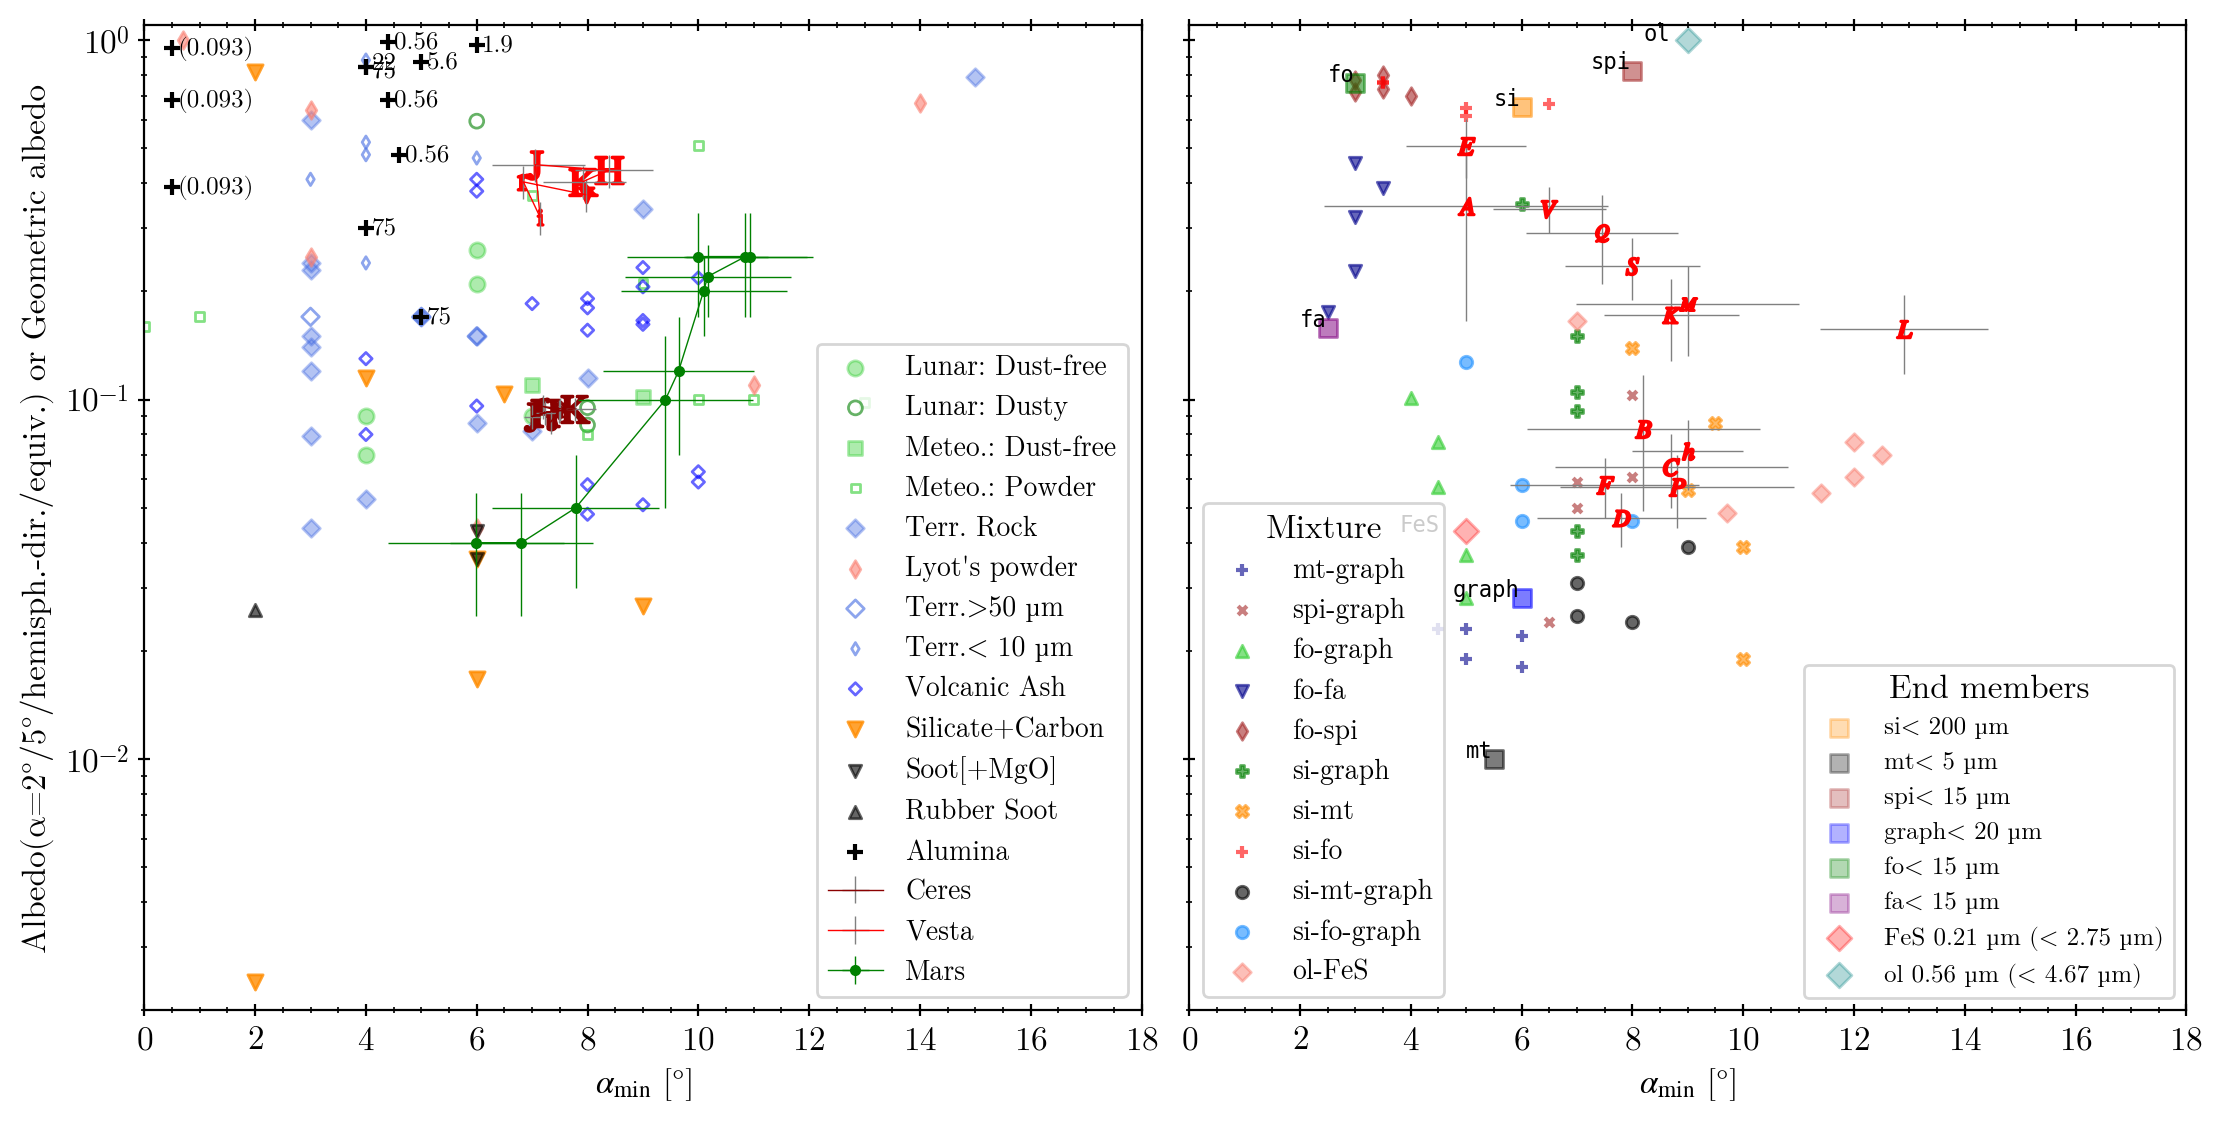

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5.5), layout="constrained", sharex=True, sharey=True, gridspec_kw=None)
axaa, axaa2 = axs
ax2 = axaa2.twinx()
axmoon = axaa.twinx()
ax2.axis("off")
axmoon.axis("off")

for k, kw in kws_lab.items():
    _df = df_lab.loc[df_lab["category"]==k].copy()
    mask = (_df["damin"] > 3) | (_df["da0"] > 3)
    _df = _df[~mask].copy()
    if np.all(np.isnan(_df["amin"])) or np.all(np.isnan(_df["_alb"])):
        continue
    axaa.scatter(np.abs(_df["amin"]), _df["_alb"], **kw)

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=100 if row.filt in "JHK" else 30)
    axaa.scatter(row["amin"], row["alb"], **mk, **kws[row.object])

for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    axaa.errorbar(_df["amin"], _df["alb"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                  xerr=(np.sqrt(_df["da0"]**2+_df["damin"]**2), np.sqrt(_df["Da0"]**2+_df["Damin"]**2)), yerr=_df["dalb"], label=objname)

# Spadaccia+2022 MIX
for typ, _kw in kws_spa22_mix.items():
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    ax2.scatter([None], [None], **kw, label=typ)
    for i, _row in _df.iterrows():
        axaa2.scatter(_row["amin"], _row["_alb"], **kw)

# Spadaccia+2022 ENDMEMBERS
for typ, _kw in kws_spa22_end.items():
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    axaa2.scatter(_df["amin"], _df["_alb"], **kw)
    kw.pop("label")
    for i, _row in _df.iterrows():
        axaa2.scatter(_row["amin"], _row["_alb"], **kw)
        axaa2.text(_row["amin"]-len(typ)*0.25, _row["_alb"]*1.01, typ, fontsize=8, fontfamily="monospace")

# SultanaR+2023
for _, _row in df_sul23.iterrows():
    marker = "s" if _row["sample"] in ["Ol", "FeS"] else "D"
    if _row["sample"] == "Ol":
        kw = dict(marker="D", color="teal", s=40, alpha=0.3, label="ol 0.56 µm (< 4.67 µm)")
        axaa2.text(_row["amin"]-0.8, _row["_alb"], "ol", fontsize=8, fontfamily="monospace")
    elif _row["sample"] == "FeS":
        kw = dict(marker="D", color="r", s=40, alpha=0.3, label="FeS 0.21 µm (< 2.75 µm)")
        axaa2.text(_row["amin"]-1.2, _row["_alb"], "FeS", fontsize=8, fontfamily="monospace")
    else:
        kw = dict(marker="D", color="salmon", s=20, alpha=0.5)
    axaa2.scatter(_row["amin"], _row["_alb"], **kw)

ax2.scatter([None], [None], marker="D", color="salmon", s=20, alpha=0.5, label="ol-FeS")

# Alumina from Geake&Geake 1990
axaa.scatter(df_alum_all["amin"], df_alum_all["albedo"]/100, marker="+", color="k", label="Alumina")

for _, row in df_alum_all.iterrows():
    sl = row["size_lambda"]
    sl_str = f"{sl}" if sl < 10 else f"{sl:.0f}"
    _y = row["albedo"]/100
    if sl == 75 and _y > 0.5:
        _y -= 0.02
    elif sl == 22:
        _y += 0.02
    elif sl == 0.093:
        sl_str = f"({sl_str})"
    if not np.isnan(_y):
        axaa.text(row["amin"]+0.1, _y, sl_str, fontsize=9, va="center")


for _, row in ast_pva0.iterrows():
    axaa2.errorbar(row.amin, row.pv, xerr=np.sqrt(row.da0**2 + row.damin**2), yerr=row.dpv, elinewidth=0.5, ecolor="gray",
                  marker=r"${}$".format(row.type), color="r")
axaa.errorbar(df_mars["amin"], df_mars["refl"], xerr=df_mars["damin"]**2,
               yerr=df_mars["drefl"], elinewidth=0.5, ecolor="g", color="g", marker=".", label="Mars", lw=0.5)

axaa.set(
    ylabel="Albedo(α=2°/5°/hemisph.-dir./equiv.) or Geometric albedo",
    xlabel="$α_\mathrm{min}$ [°]",
    yscale='log',
    xlim=(0,18), ylim=(0.002, 1.1)
)
axaa2.set(
    xlabel="$α_\mathrm{min}$ [°]",
)
axaa.legend(loc=4, fontsize=10)
axaa2.legend(loc=4, fontsize=9, ncol=1, title="End members")
ax2.legend(loc=3, fontsize=10, title="Mixture")
plt.savefig("figs/amin-albedo.pdf", dpi=300)
plt.show();

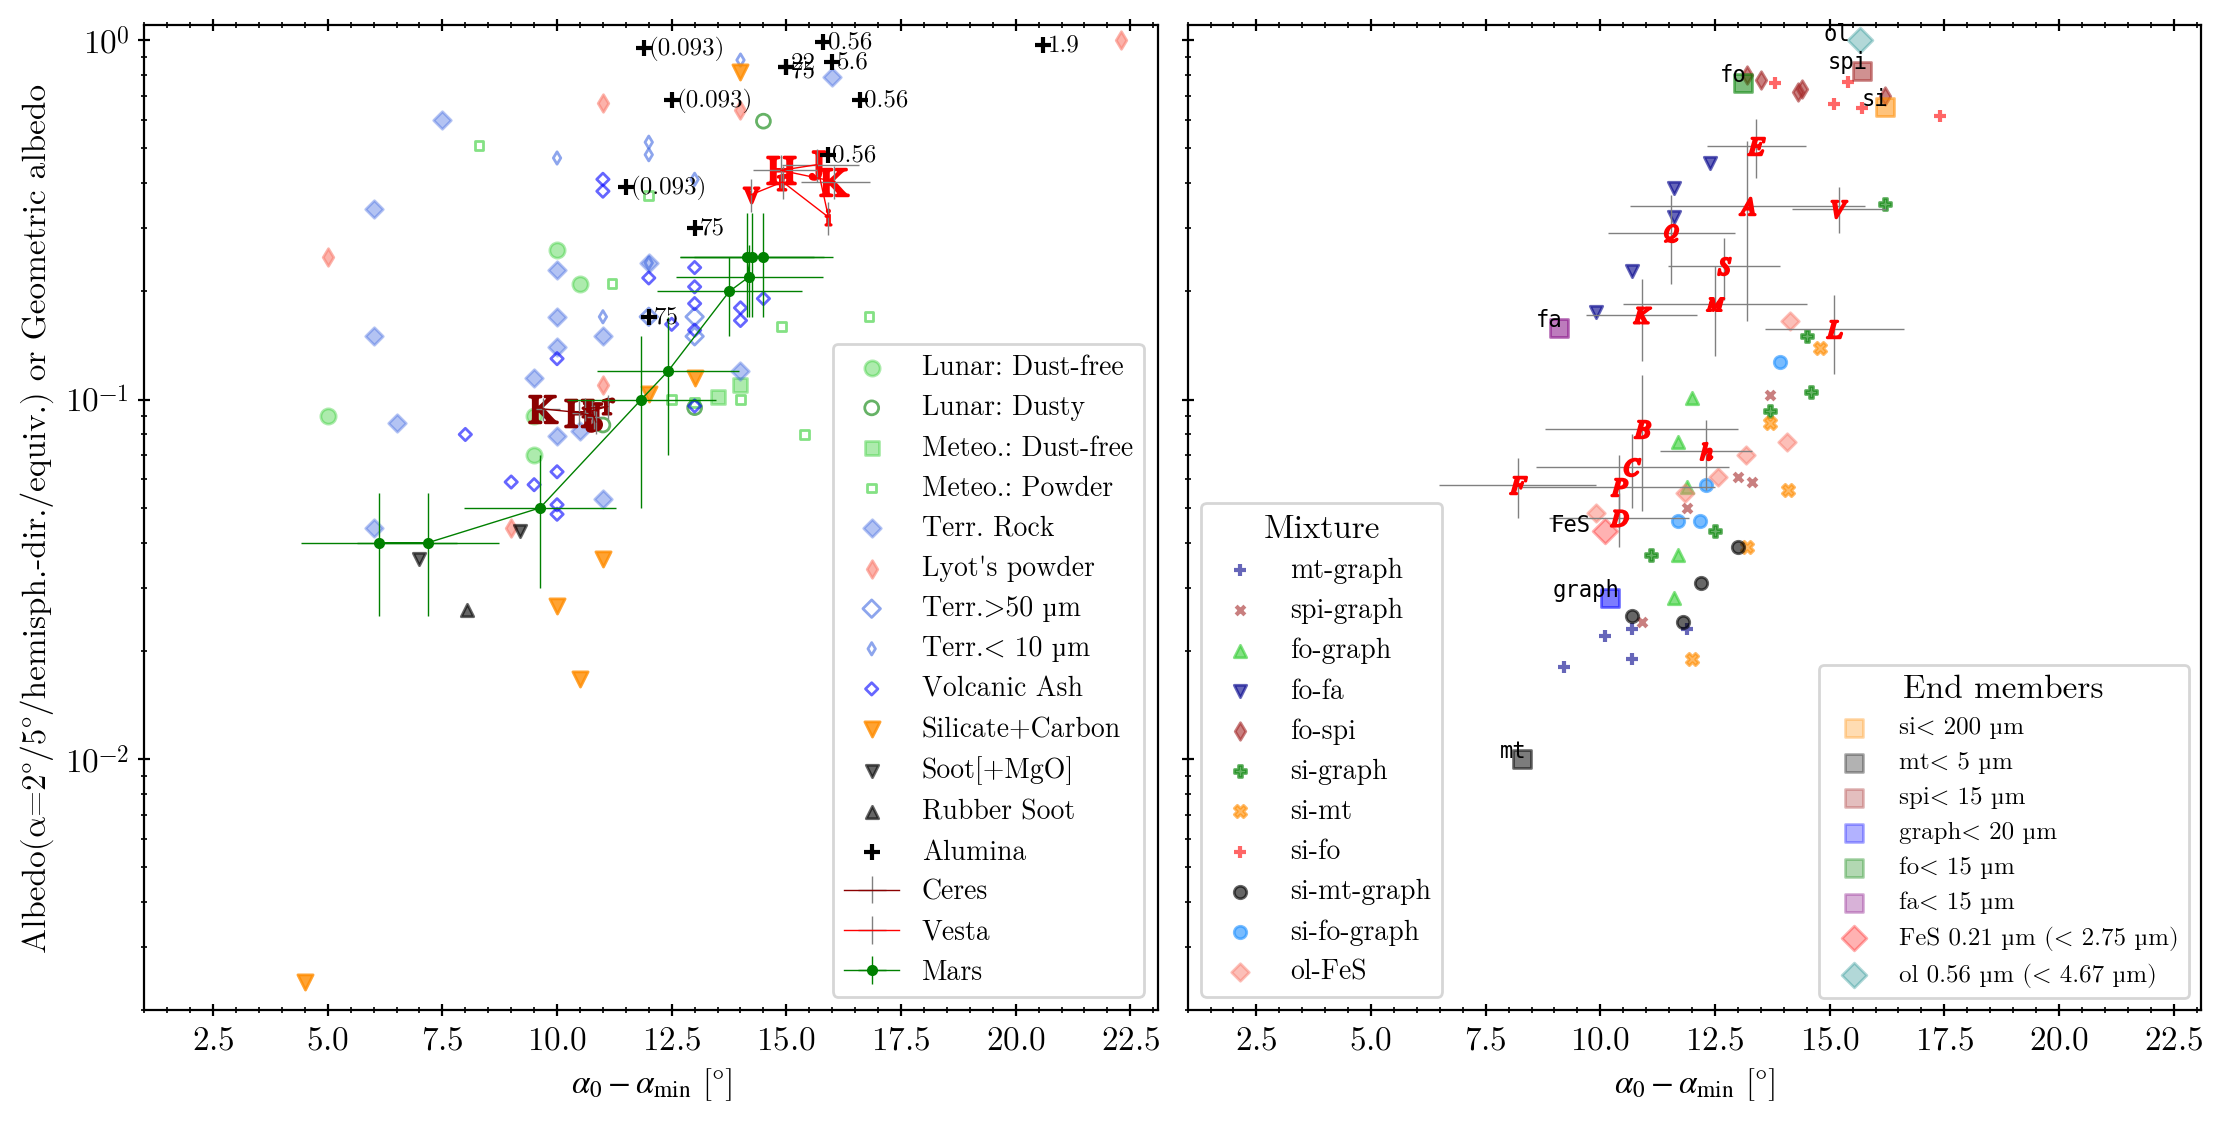

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5.5), layout="constrained", sharex=True, sharey=True, gridspec_kw=None)
axaa, axaa2 = axs
ax2 = axaa2.twinx()
axmoon = axaa.twinx()
ax2.axis("off")
axmoon.axis("off")

for k, kw in kws_lab.items():
    _df = df_lab.loc[df_lab["category"]==k].copy()
    mask = (_df["damin"] > 3) | (_df["da0"] > 3)
    _df = _df[~mask].copy()
    if np.all(np.isnan(_df["a0"] - _df["amin"])) or np.all(np.isnan(_df["_alb"])):
        continue
    axaa.scatter(np.abs(_df["a0"] - _df["amin"]), _df["_alb"], **kw)

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=100 if row.filt in "JHK" else 30)
    axaa.scatter(row["a0"] - row["amin"], row["alb"], **mk, **kws[row.object])

for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    axaa.errorbar(_df["a0"] - _df["amin"], _df["alb"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                  xerr=(np.sqrt(_df["da0"]**2+_df["damin"]**2), np.sqrt(_df["Da0"]**2+_df["Damin"]**2)), yerr=_df["dalb"], label=objname)

# Spadaccia+2022 MIX
for typ, _kw in kws_spa22_mix.items():
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    ax2.scatter([None], [None], **kw, label=typ)
    for i, _row in _df.iterrows():
        axaa2.scatter(_row["a0"] - _row["amin"], _row["_alb"], **kw)

# Spadaccia+2022 ENDMEMBERS
for typ, _kw in kws_spa22_end.items():
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    axaa2.scatter(_df["a0"] - _df["amin"], _df["_alb"], **kw)
    kw.pop("label")
    for i, _row in _df.iterrows():
        axaa2.scatter(_row["a0"] - _row["amin"], _row["_alb"], **kw)
        axaa2.text(_row["a0"] - _row["amin"]-len(typ)*0.25, _row["_alb"]*1.01, typ, fontsize=8, fontfamily="monospace")

# SultanaR+2023
for _, _row in df_sul23.iterrows():
    marker = "s" if _row["sample"] in ["Ol", "FeS"] else "D"
    if _row["sample"] == "Ol":
        kw = dict(marker="D", color="teal", s=40, alpha=0.3, label="ol 0.56 µm (< 4.67 µm)")
        axaa2.text(_row["a0"] - _row["amin"]-0.8, _row["_alb"], "ol", fontsize=8, fontfamily="monospace")
    elif _row["sample"] == "FeS":
        kw = dict(marker="D", color="r", s=40, alpha=0.3, label="FeS 0.21 µm (< 2.75 µm)")
        axaa2.text(_row["a0"] - _row["amin"]-1.2, _row["_alb"], "FeS", fontsize=8, fontfamily="monospace")
    else:
        kw = dict(marker="D", color="salmon", s=20, alpha=0.5)
    axaa2.scatter(_row["a0"] - _row["amin"], _row["_alb"], **kw)

ax2.scatter([None], [None], marker="D", color="salmon", s=20, alpha=0.5, label="ol-FeS")

# Alumina from Geake&Geake 1990
axaa.scatter(df_alum_all["a0"]-df_alum_all["amin"], df_alum_all["albedo"]/100, marker="+", color="k", label="Alumina")

for _, row in df_alum_all.iterrows():
    sl = row["size_lambda"]
    sl_str = f"{sl}" if sl < 10 else f"{sl:.0f}"
    _y = row["albedo"]/100
    if sl == 75 and _y > 0.5:
        _y -= 0.02
    elif sl == 22:
        _y += 0.02
    elif sl == 0.093:
        sl_str = f"({sl_str})"
    if not np.isnan(_y):
        axaa.text(row["a0"] - row["amin"]+0.1, _y, sl_str, fontsize=9, va="center")


for _, row in ast_pva0.iterrows():
    axaa2.errorbar(row.a0-row.amin, row.pv, xerr=np.sqrt(row.da0**2 + row.damin**2), yerr=row.dpv, elinewidth=0.5, ecolor="gray",
                  marker=r"${}$".format(row.type), color="r")
axaa.errorbar(df_mars["a0"]-df_mars["amin"], df_mars["refl"], xerr=np.sqrt(df_mars["da0"]**2 + df_mars["damin"]**2),
               yerr=df_mars["drefl"], elinewidth=0.5, ecolor="g", color="g", marker=".", label="Mars", lw=0.5)

axaa.set(
    ylabel="Albedo(α=2°/5°/hemisph.-dir./equiv.) or Geometric albedo",
    xlabel="$α_0 - α_\mathrm{min}$ [°]",
    yscale='log',
    xlim=(1,23.1), ylim=(0.002, 1.1)
)
axaa2.set(
    xlabel="$α_0 - α_\mathrm{min}$ [°]",
)
axaa.legend(loc=4, fontsize=10)
axaa2.legend(loc=4, fontsize=9, ncol=1, title="End members")
ax2.legend(loc=3, fontsize=10, title="Mixture")
plt.savefig("figs/a0-amin-albedo.pdf", dpi=300)
plt.show();

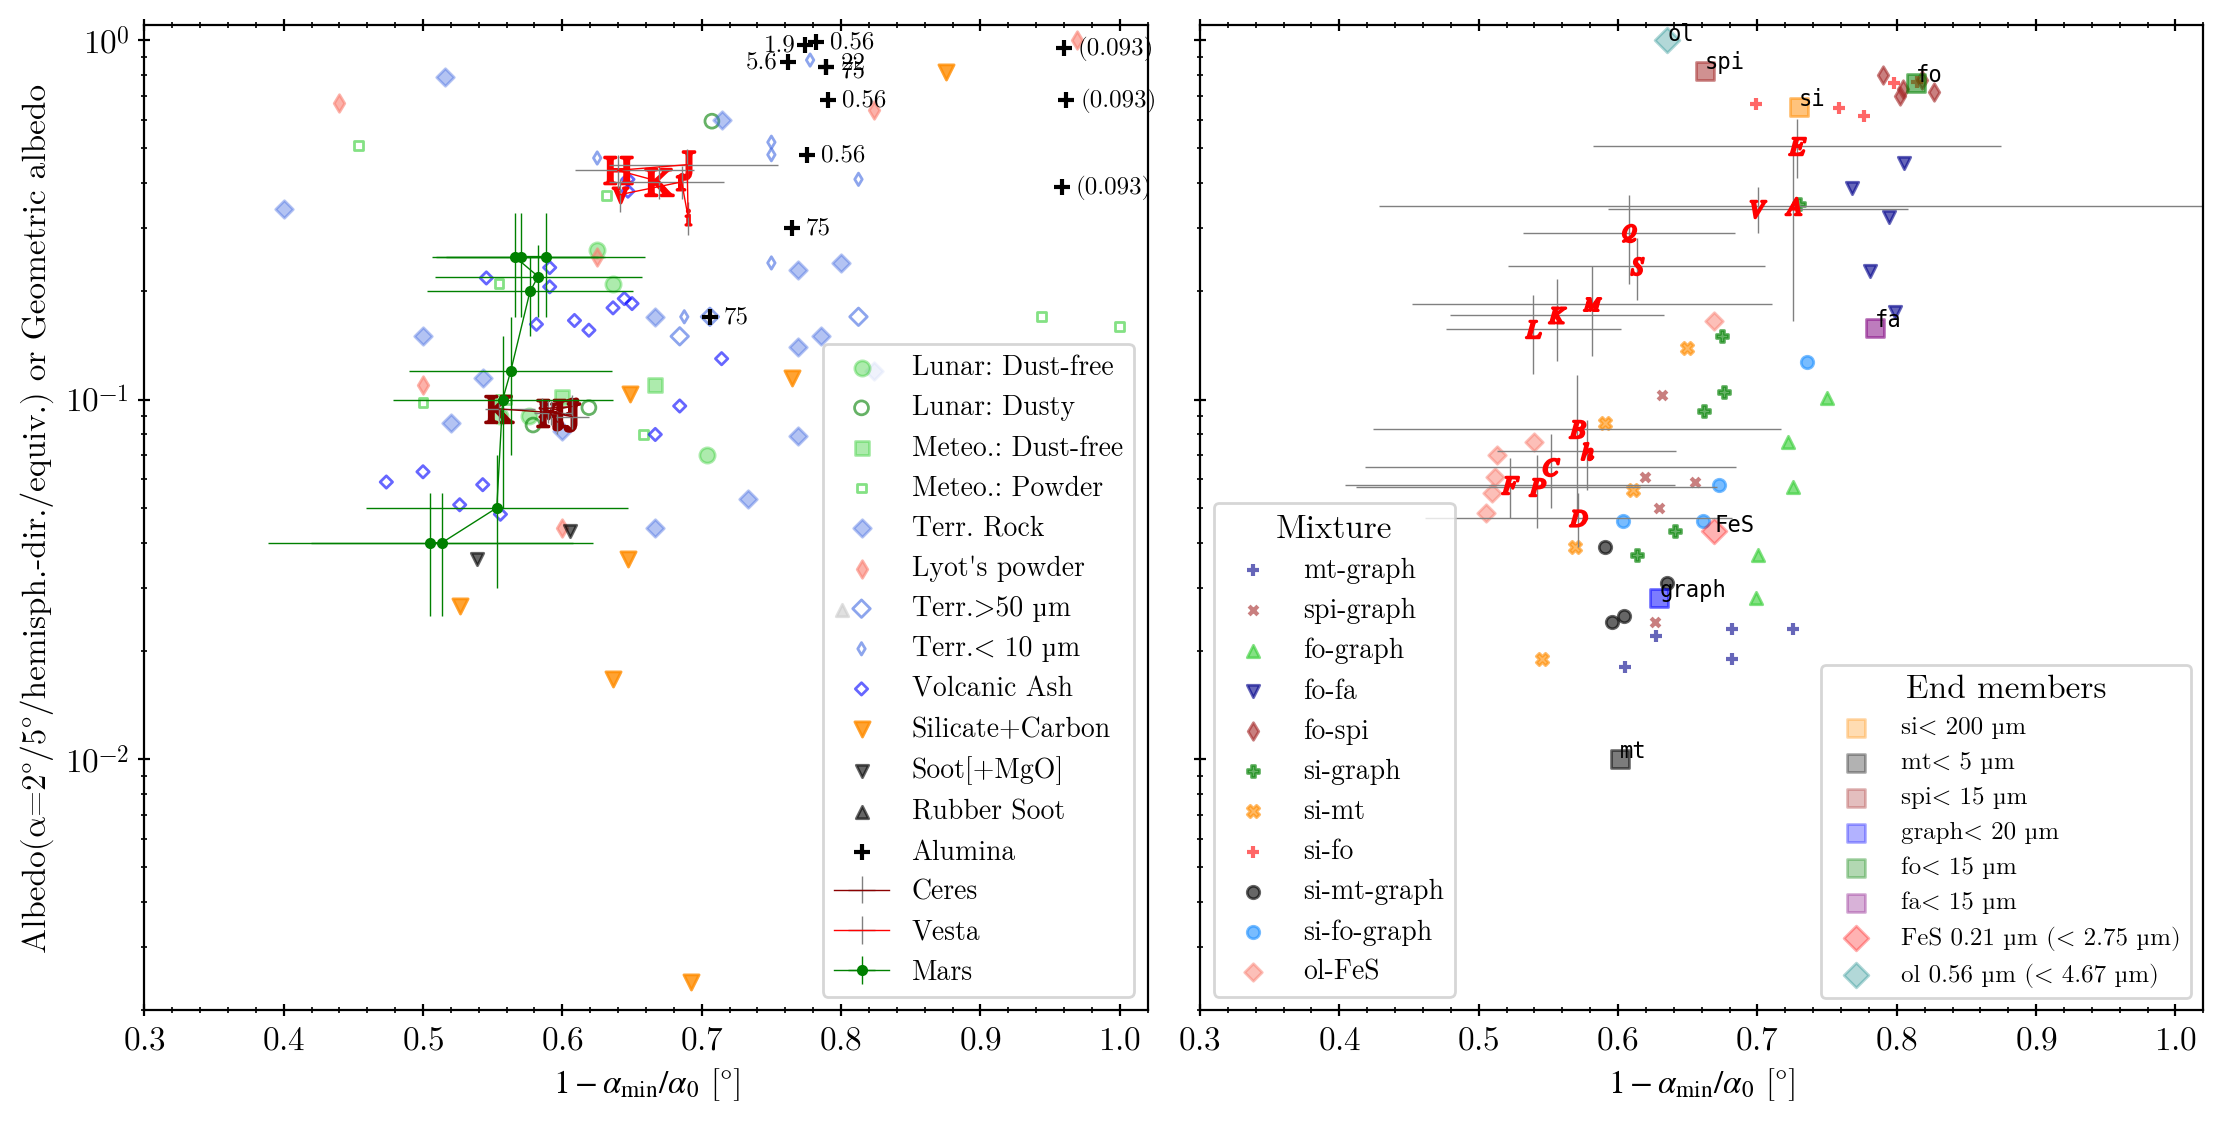

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5.5), layout="constrained", sharex=True, sharey=True, gridspec_kw=None)
axaa, axaa2 = axs
ax2 = axaa2.twinx()
axmoon = axaa.twinx()
ax2.axis("off")
axmoon.axis("off")

for k, kw in kws_lab.items():
    _df = df_lab.loc[df_lab["category"]==k].copy()
    mask = (_df["damin"] > 3) | (_df["da0"] > 3)
    _df = _df[~mask].copy()
    if np.all(np.isnan(1 - _df["amin"]/_df["a0"])) or np.all(np.isnan(_df["_alb"])):
        continue
    axaa.scatter(np.abs(1 - _df["amin"]/_df["a0"]), _df["_alb"], **kw)

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=100 if row.filt in "JHK" else 30)
    axaa.scatter(np.abs(1 - row["amin"]/row["a0"]), row["alb"], **mk, **kws[row.object])

for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    skew = np.abs(1 - _df["amin"]/_df["a0"])
    axaa.errorbar(skew, _df["alb"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                  xerr=(skew*np.sqrt((_df.damin/_df.amin)**2+(_df.da0/_df.a0)**2),
                        skew*np.sqrt((_df.Damin/_df.amin)**2+(_df.Da0/_df.a0)**2)),
                  yerr=_df["dalb"], label=objname)

# Spadaccia+2022 MIX
for typ, _kw in kws_spa22_mix.items():
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    ax2.scatter([None], [None], **kw, label=typ)
    for i, _row in _df.iterrows():
        axaa2.scatter(1 - _row["amin"]/_row["a0"], _row["_alb"], **kw)

# Spadaccia+2022 ENDMEMBERS
for typ, _kw in kws_spa22_end.items():
    _df = df_spa22.loc[(df_spa22["sample"] == typ) & (df_spa22["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    axaa2.scatter(1 - _df["amin"]/_df["a0"], _df["_alb"], **kw)
    kw.pop("label")
    for i, _row in _df.iterrows():
        axaa2.scatter(1 - _row["amin"]/_row["a0"], _row["_alb"], **kw)
        axaa2.text(1 - _row["amin"]/_row["a0"], _row["_alb"]*1.01, typ, fontsize=8, fontfamily="monospace")

# SultanaR+2023
for _, _row in df_sul23.iterrows():
    marker = "s" if _row["sample"] in ["Ol", "FeS"] else "D"
    if _row["sample"] == "Ol":
        kw = dict(marker="D", color="teal", s=40, alpha=0.3, label="ol 0.56 µm (< 4.67 µm)")
        axaa2.text(1 - _row["amin"]/_row["a0"], _row["_alb"], "ol", fontsize=8, fontfamily="monospace")
    elif _row["sample"] == "FeS":
        kw = dict(marker="D", color="r", s=40, alpha=0.3, label="FeS 0.21 µm (< 2.75 µm)")
        axaa2.text(1 - _row["amin"]/_row["a0"], _row["_alb"], "FeS", fontsize=8, fontfamily="monospace")
    else:
        kw = dict(marker="D", color="salmon", s=20, alpha=0.5)
    axaa2.scatter(1 - _row["amin"]/_row["a0"], _row["_alb"], **kw)

ax2.scatter([None], [None], marker="D", color="salmon", s=20, alpha=0.5, label="ol-FeS")

# Alumina from Geake&Geake 1990
axaa.scatter(1-df_alum_all["amin"]/df_alum_all["a0"], df_alum_all["albedo"]/100, marker="+", color="k", label="Alumina")

for _, row in df_alum_all.iterrows():
    sl = row["size_lambda"]
    sl_str = f"{sl}" if sl < 10 else f"{sl:.0f}"
    _x = 1 - row["amin"]/row["a0"]
    _y = row["albedo"]/100
    if sl == 75 and _y > 0.5:
        _y -= 0.02
    elif sl == 22:
        _y += 0.02
    elif sl in [1.9, 5.6]:
        _x -= 0.04
    elif sl == 0.093:
        sl_str = f"({sl_str})"
    if not np.isnan(_y):
        axaa.text(_x+0.01, _y, sl_str, fontsize=9, va="center")


for _, row in ast_pva0.iterrows():
    skew = 1-row.amin/row.a0
    dskew = skew*np.sqrt((row.damin/row.amin)**2+(row.da0/row.a0)**2)
    axaa2.errorbar(skew, row.pv, xerr=dskew, yerr=row.dpv, elinewidth=0.5, ecolor="gray",
                  marker=r"${}$".format(row.type), color="r")

_skew = 1 - df_mars["amin"]/df_mars["a0"]
_dskew = _skew*np.sqrt((df_mars["damin"]/df_mars["amin"])**2+(df_mars["da0"]/df_mars["a0"])**2)
axaa.errorbar(_skew, df_mars["refl"], xerr=_dskew, yerr=df_mars["drefl"], elinewidth=0.5, ecolor="g", color="g", marker=".", label="Mars", lw=0.5)

axaa.set(
    ylabel="Albedo(α=2°/5°/hemisph.-dir./equiv.) or Geometric albedo",
    xlabel="$1 - α_\mathrm{min}/α_0$ [°]",
    yscale='log',
    xlim=(0.3, 1.02), ylim=(0.002, 1.1)
)
axaa2.set(
    xlabel="$1 - α_\mathrm{min}/α_0$ [°]",
)
axaa.legend(loc=4, fontsize=10)
axaa2.legend(loc=4, fontsize=9, ncol=1, title="End members")
ax2.legend(loc=3, fontsize=10, title="Mixture")
plt.savefig("figs/a0-skew-albedo.pdf", dpi=300)
plt.show();

## Pmin-a0-amin space

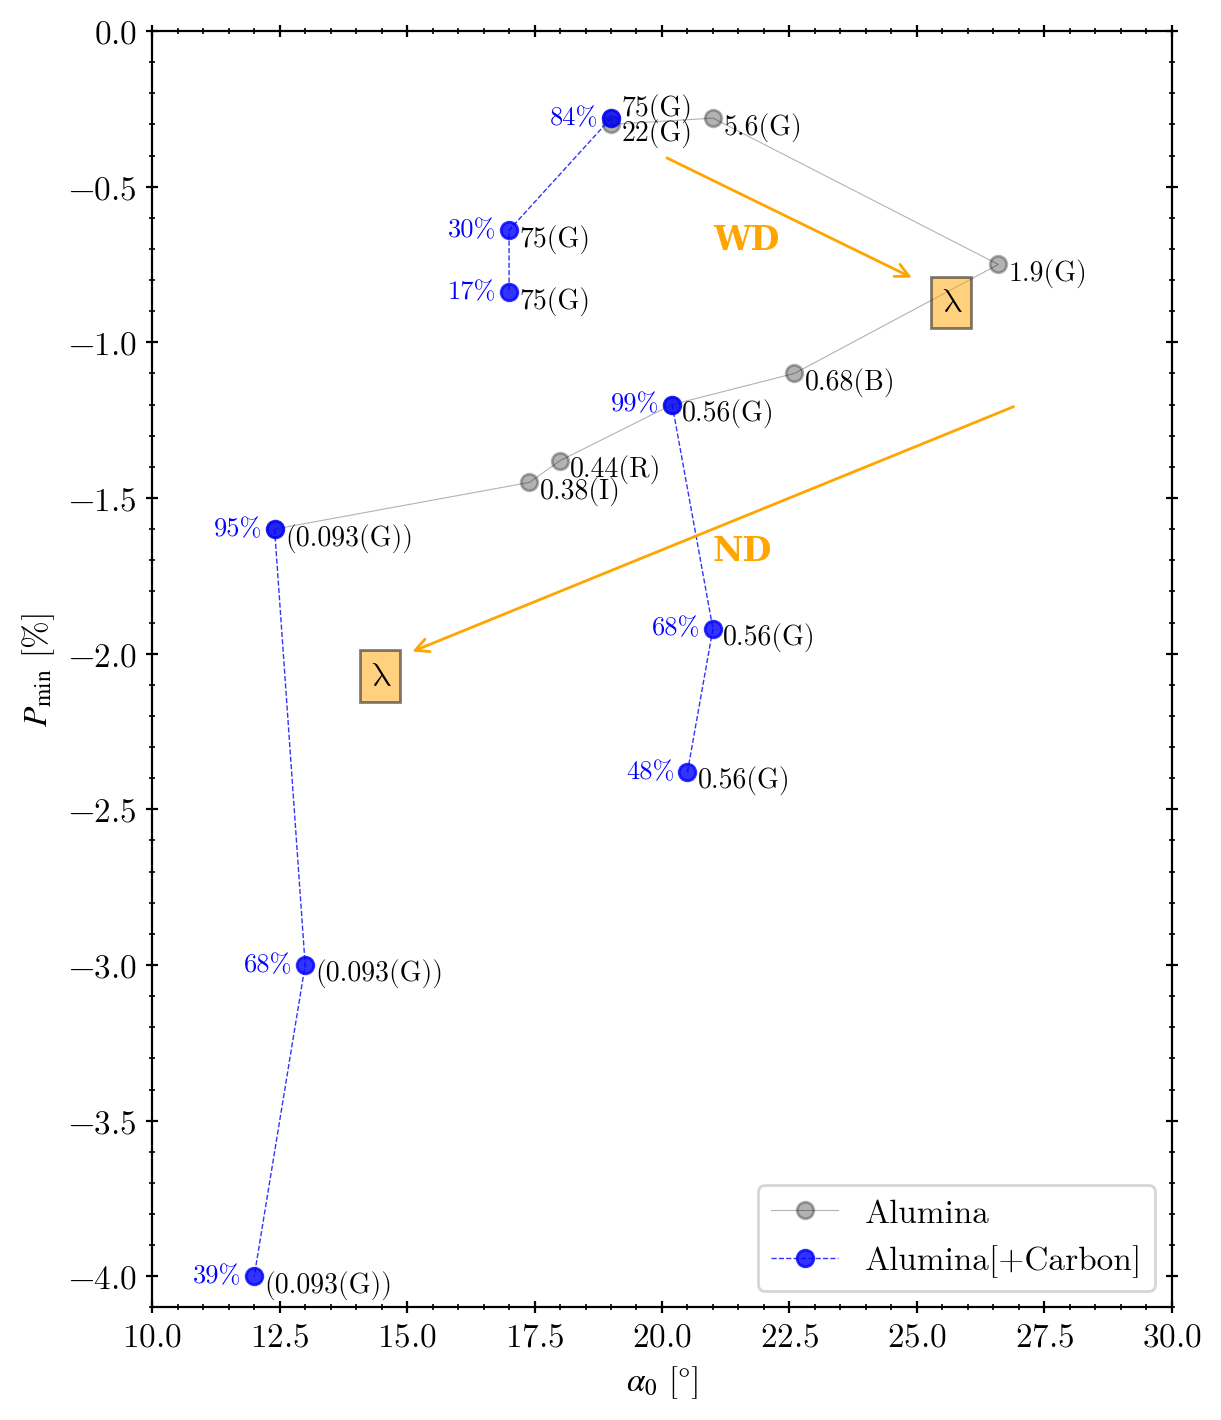

In [12]:
df_alum_pure = df_alum_all.loc[df_alum_all["material"]=="Al2O3"].copy()

fig, axs = plt.subplots(1, 1, figsize=(6,7), sharex=False, sharey=True, gridspec_kw=None)

ax1 = axs
# ax2 = axs[1]

# Lunar observation from Shkuratov+1992
# for _id in df_lunar.id.unique():
#     _rowb = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.42)]
#     _rowr = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.65)]
#     for aa in [ax2]:
#         aa.scatter(_rowb["a0"], -_rowb["P10.5"], **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
#         aa.scatter(_rowr["a0"], -_rowr["P10.5"], **kws_lunar[_rowb["type"].iloc[0]], color="m")
#         aa.plot((_rowr["a0"], _rowb["a0"]), (-_rowr["P10.5"], -_rowb["P10.5"]), "k-", lw=0.2)
# for typ, kw in kws_lunar.items():
#     ax2.scatter(np.nan, np.nan, **kw, color="k", label=typ.capitalize())


# Experiments from Shkuratov+1992
# for typ, kw in kws_shk92lab.items():
#     if typ != "Transparent glass powder":
#         continue
#     _df = df_shk92lab.loc[df_shk92lab["type"]==typ].copy()
#     ax1.scatter(_df["a0"], _df["pmin"], **kw, label=typ)
# ax1.annotate("200µm", xy=(8.8, -0.1), xytext=(7.2, -0.2), fontsize=9, color="g",
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="g"))
# ax1.annotate("<0.5µm", xy=(22.3, -0.78), xytext=(22, -0.5), fontsize=9, color="g",
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="g"))

# Alumina from Geake+1990
for i, row in df_alum_all.iterrows():
    yoff = 0.01 if i==0 else -0.05
    fmt = "{}" if row["size_lambda"] < 1  else "{:.1f}" if row["size_lambda"] < 10 else "{:.0f}"
    fmt += f"({row['filter_name'][0].upper()})"
    if row["size_lambda"] == 0.093:
        fmt = f"({fmt})"
    ax1.text(row["a0"]+.2, row["Pmin"] + yoff, fmt.format(row["size_lambda"]), fontsize=10)

ax1.plot(df_alum_pure["a0"], df_alum_pure["Pmin"], "ko-", alpha=0.3, lw=0.4, label="Alumina")

for size_lam in df_alum_all.size_lambda.unique():
    _df = df_alum_all.loc[df_alum_all["size_lambda"] == size_lam]
    if len(_df) > 1:
        for _, _row in _df.iterrows():
            ax1.text(_row["a0"]-1.2, _row["Pmin"]-0.02, f'{_row["albedo"]:.0f}%', color="b", fontsize=9.5)
        ax1.plot(_df["a0"], _df["Pmin"], "bo--", alpha=0.8, lw=0.5)
ax1.plot([None], [None], "bo--", alpha=0.8, lw=0.5, label="Alumina[+Carbon]")
# ax.plot(df_alum["a0"], df_alum["Pmin"], marker="", color="gray", lw=1)

ax1.annotate("", xy=(25, -0.8), xytext=(20, -0.4), arrowprops=dict(arrowstyle="->", color="orange"))
ax1.annotate("", xy=(15, -2.0), xytext=(27, -1.2), arrowprops=dict(arrowstyle="->", color="orange"))
ax1.text(25.5, -0.9, "λ", bbox=dict(facecolor='orange', alpha=0.5))
ax1.text(14.3, -2.1, "λ", bbox=dict(facecolor='orange', alpha=0.5))
ax1.text(21, -0.7, "WD", color="orange", fontfamily="serif", fontweight="black")
ax1.text(21, -1.7, "ND", color="orange", fontfamily="serif", fontweight="black")

ax1.legend(loc=4, fontsize=12)
# ax2.legend(loc=3, fontsize=10, ncol=3)
ax1.set(
    xlabel=r"$\alpha_0$ [°]", ylabel=r"$P_\mathrm{min}$ [%]", xlim=(10, 30), ylim=(-4.1, 0.)
)
# ax2.set(
#     xlabel=r"$\alpha_0$ [°]", ylabel=r"$P_\mathrm{min}$ [%]", xlim=(5, 35)
# )
plt.tight_layout(pad=0.1)
plt.savefig("figs/pmin-a0-lab-simple.pdf", dpi=300)
plt.show();

/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_77102/1890806432.py:139: UserWarning: Glyph 65038 (\N{VARIATION SELECTOR-15}) missing from current font.
  plt.savefig("figs/pmin-a0-lab.pdf", dpi=300)
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_77102/1890806432.py:139: UserWarning: Glyph 65038 (\N{VARIATION SELECTOR-15}) missing from current font.
  plt.savefig("figs/pmin-a0-lab.pdf", dpi=300)
/Users/ysbach/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65038 (\N{VARIATION SELECTOR-15}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


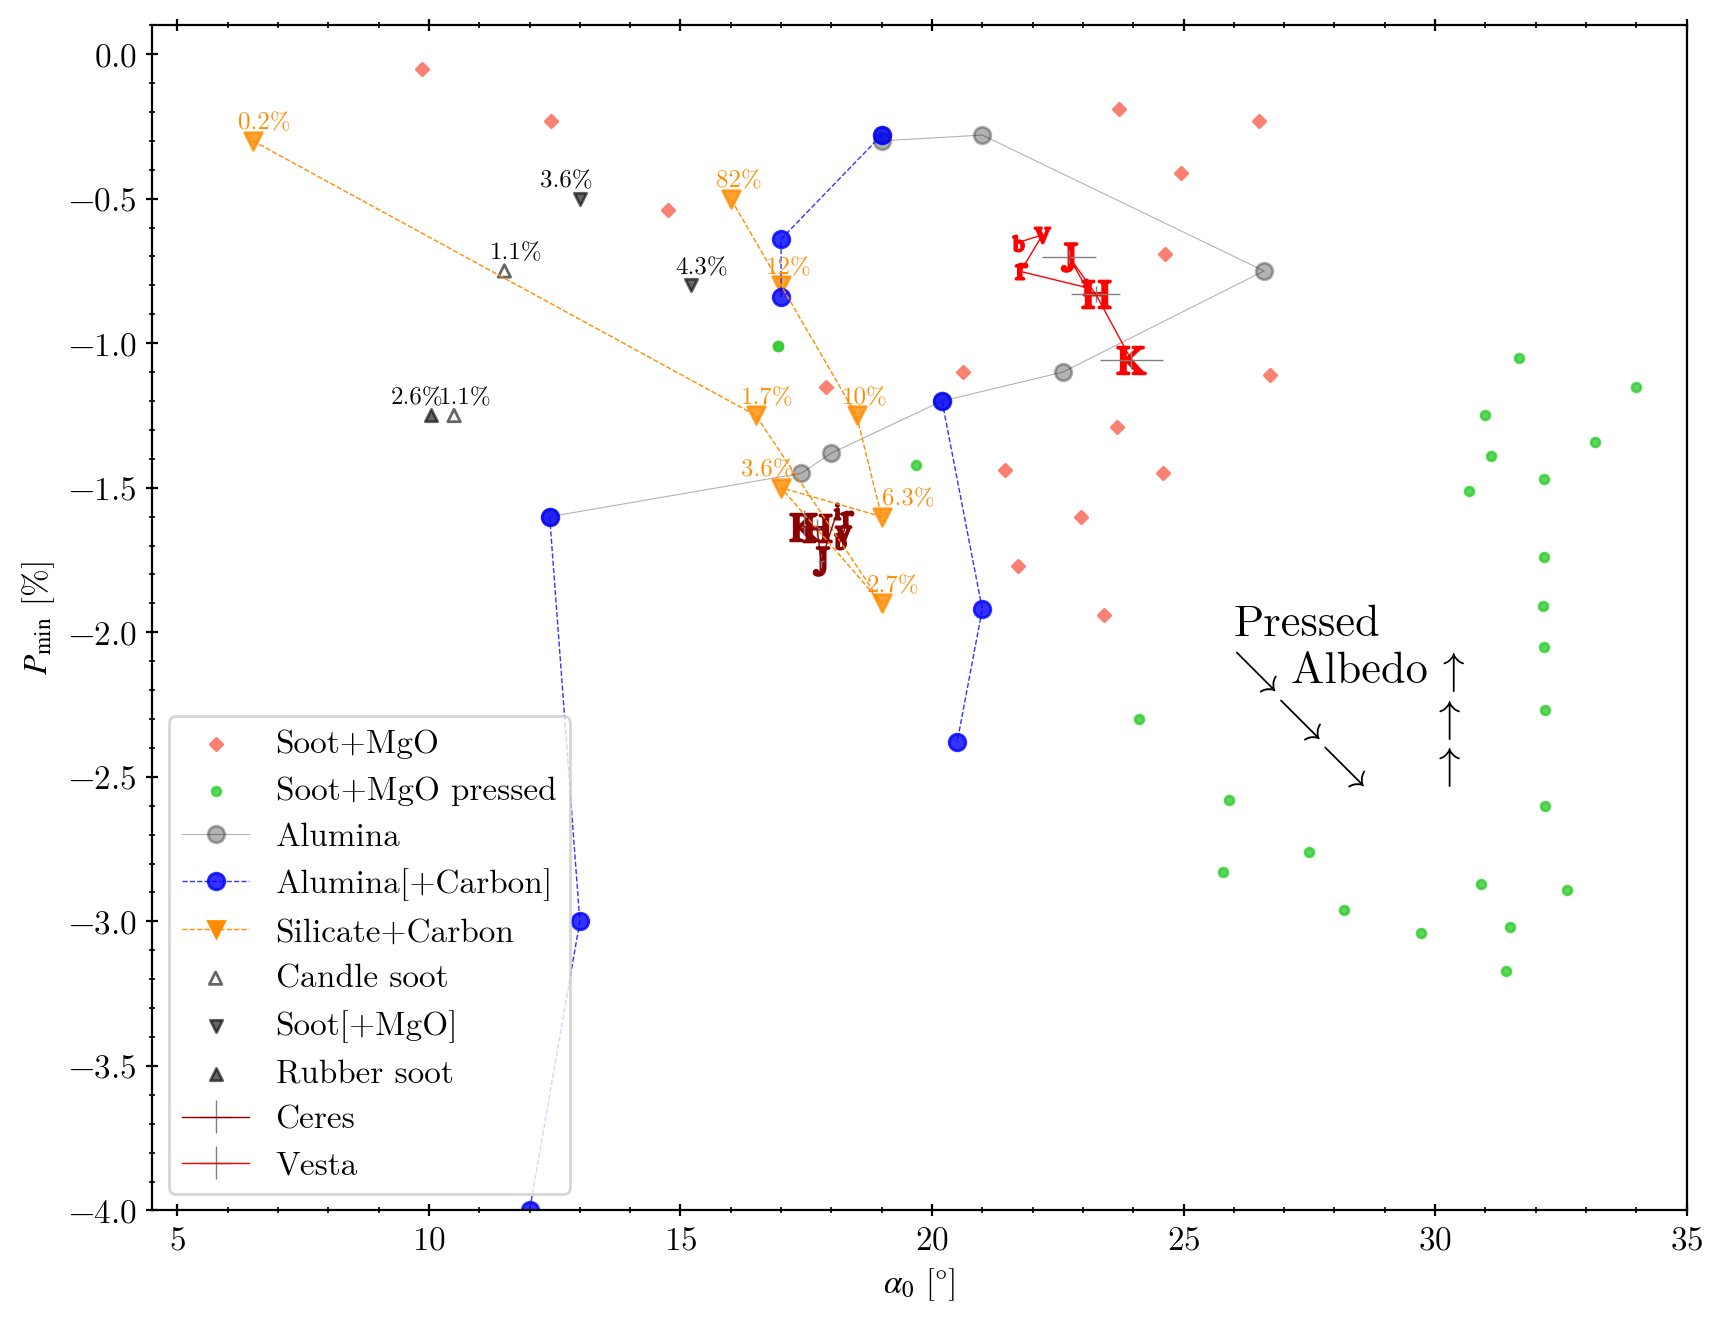

In [13]:
kws_shk92lab = {
    'Transparent glass powder': dict(marker="s", color="g", s=10, facecolor="none"),
    'Soot+MgO': dict(marker="D", facecolor="salmon", s=10, color="salmon"),
    'Soot+MgO pressed': dict(marker="o", facecolors="limegreen", s=10, color="limegreen", alpha=0.8)
}

kws_shk94lab = {
    'clear glass powder': dict(marker="s", color="g", s=10, facecolor="none", label="clear"),
}

kws_lunar = {
    "maria": dict(marker="o", s=30, facecolors="none", alpha=0.6),
    "highland": dict(marker="s",s=30,  facecolors="none", alpha=0.6),
    "mare crater": dict(marker=r"$\oplus$", s=30, linewidths=0.5, alpha=0.6),
    "highland crater": dict(marker=r"$\boxplus$", s=30, facecolors="none", linewidths=0.5, alpha=0.6),
}

kws_lab = {
#     'Lunar Dust-Free':dict(marker="o", s=50, alpha=0.6, color="limegreen", label="Lunar: Dust-free"),
#     'Lunar Dusty':dict(marker="o", facecolors="none", s=25, alpha=0.6, color="limegreen", label="Lunar: Dusty"),
    'Lunar Fine':dict(marker="o", facecolors="none", s=5, alpha=0.6, color="k", label="Lunar: Fine"),
#     'Met Dust-Free':dict(marker="s", s=50, alpha=0.6, color="limegreen", label="Meteo.: Dust-free"),
    'Met Powder':dict(marker="s", facecolors="none", s=10, alpha=0.6, color="limegreen", label="Meteo.: Powder"),
#     'Rock Dust-Free':dict(marker="D", s=40, alpha=0.6, color="royalblue", label="Terr.: Dust-Free"),
    'Rock Powder 340':dict(marker="D", facecolors="none", s=25, alpha=0.6, color="royalblue", label="Terr.>50 µm"),
    'Rock Powder 50':dict(marker="d", s=20, alpha=0.6, color="royalblue", label="Terr.<25-50 µm"),
    'Rock Powder 25':dict(marker="d", facecolors="none", s=20, alpha=0.6, color="royalblue", label="Terr.< 25 µm"),
    'Rock Powder 10':dict(marker="d", facecolors="none", s=10, alpha=0.6, color="royalblue", label="Terr.< 10 µm"),
    'Volcanic Ash':dict(marker="D", facecolors="none", s=10, alpha=0.6, color="blue", label="Volcanic Ash"),
    "silica+carbon":dict(marker="v", s=40, alpha=0.8, color="darkorange", label="Silicate+Carbon"),
    "Candle Soot":dict(marker="^", facecolors="none", s=20, alpha=0.6, color="k", label="Candle soot"),
    "Soot":dict(marker="v", s=20, alpha=0.6, color="k", label="Soot[+MgO]"),
    "Rubber Soot":dict(marker="^", s=20, alpha=0.6, color="k", label="Rubber soot"),
}

df_alum_pure = df_alum_all.loc[df_alum_all["material"]=="Al2O3"].copy()

fig, axs = plt.subplots(1, 1, figsize=(8.5,6.5), layout="constrained", sharex=False, sharey=True, gridspec_kw=None)

ax1 = axs
ax2 = ax1.twinx()
ax2.axis("off")

# Lunar observation from Shkuratov+1992
# for _id in df_lunar.id.unique():
#     _rowb = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.42)]
#     _rowr = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.65)]
#     for aa in [ax2]:
#         aa.scatter(_rowb["a0"], -_rowb["P10.5"], **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
#         aa.scatter(_rowr["a0"], -_rowr["P10.5"], **kws_lunar[_rowb["type"].iloc[0]], color="m")
#         aa.plot((_rowr["a0"], _rowb["a0"]), (-_rowr["P10.5"], -_rowb["P10.5"]), "k-", lw=0.2)
# for typ, kw in kws_lunar.items():
#     ax2.scatter(np.nan, np.nan, **kw, color="k", label=typ.capitalize())


# Experiments from Shkuratov+1992
for typ, kw in kws_shk92lab.items():
    if typ == "Transparent glass powder":
        continue
    _df = df_shk92lab.loc[df_shk92lab["type"]==typ].copy()
    ax1.scatter(_df["a0"], _df["pmin"], **kw, label=typ)
ax1.text(26, -2.5, "Pressed\n↘︎Albedo ↑\n   ↘︎       ↑\n      ↘︎    ↑", fontsize=16)
# ax1.annotate("200µm", xy=(8.7, -0.1), xytext=(8.5, 0.02), fontsize=9, color="g",
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="g"))
# ax1.annotate("<0.5µm", xy=(22.3, -0.78), xytext=(21.5, -0.5), fontsize=9, color="g",
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="g"))
# ax1.annotate("0.5µm", xy=(23, -1.15), xytext=(21.5, -1.3), fontsize=9, color="g",
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="g"))

# Alumina from Geake+1990
# for i, row in df_alum_all.iterrows():
#     yoff = 0.01 if i==0 else -0.05
#     fmt = "{:.2f}" if row["size_lambda"] < 1  else "{:.1f}" if row["size_lambda"] < 10 else "{:.0f}"
#     fmt += f"({row['filter_name'][0].upper()})"
#     ax1.text(row["a0"]+.2, row["Pmin"] + yoff, fmt.format(row["size_lambda"]), fontsize=9)

ax1.plot(df_alum_pure["a0"], df_alum_pure["Pmin"], "ko-", alpha=0.3, lw=0.4, label="Alumina")

for size_lam in df_alum_all.size_lambda.unique():
    # if size_lam == 0.093:
    #     continue
    _df = df_alum_all.loc[df_alum_all["size_lambda"] == size_lam]
    if len(_df) > 1:
        # for _, _row in _df.iterrows():
        #     ax1.text(_row["a0"]-1.2, _row["Pmin"]-0.02, f'{_row["albedo"]:.0f}%', color="b", fontsize=9)
        ax1.plot(_df["a0"], _df["Pmin"], "bo--", alpha=0.8, lw=0.5)
ax1.plot([None], [None], "bo--", alpha=0.8, lw=0.5, label="Alumina[+Carbon]")
# ax.plot(df_alum["a0"], df_alum["Pmin"], marker="", color="gray", lw=1)

# Experiments by Geake+1986 and Zellner+1977ab etc
for typ, _kw in kws_lab.items():
    _df = df_lab.loc[df_lab["category"] == typ].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    if typ in ["Soot", "silica+carbon", "Candle Soot", "Rubber Soot"]:
        kw = _kw.copy()
        if typ in ["silica+carbon"]:
            _kw = dict(ls="--", color=kw["color"], mfc=kw.get("facecolors"), lw=0.5)
            ax1.plot(_df["a0"], _df["Pmin"], **_kw, marker="")
            ax1.plot([np.nan], [np.nan], **_kw, marker=kw["marker"], label=kw.pop("label"))
            ax1.scatter(_df["a0"], _df["Pmin"], **kw)
        else:
            ax1.scatter(_df["a0"], _df["Pmin"], **kw)
        for i, _row in _df.iterrows():
            if (_alb := _row["_alb"]) > 0:
                _a = f'{_row["_alb"]*100:.0f}%' if _alb > 0.1 else f'{_alb*100:.1f}%'
                _offx = -0.8 if _alb in [0.026, 0.036] else 0 if _alb==0.063 else -0.3
                _offy = 0.04
                ax1.text(_row["a0"]+_offx, _row["Pmin"]+_offy, _a, color=kw["color"], fontsize=9)
#     else:
#         ax2.scatter(_df["a0"], _df["Pmin"], ls="", **kw)

# for typ, c in zip(["clear", "green", "black"], ["dodgerblue", "limegreen", "gray"]):
#     _df = df_shk94lab.loc[df_shk94lab["type"]==(typ+" glass powder")].copy().sort_values("d").reset_index(drop=True)
#     ax1.scatter(_df["a0"][0], _df["Pmin"][0], marker="s", color=c, s=10)
#     ax1.scatter(_df["a0"][1], _df["Pmin"][1], marker="o", color=c, s=10)
#     ax1.annotate("", xy=(_df["a0"][0], _df["Pmin"][0]), xytext=(_df["a0"][1], _df["Pmin"][1]), color=c,
#                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color=c, lw=1, ls=":"))
#     ax2.plot([None], [None], color=c, lw=2, ls=":", marker="$>$", label=typ.capitalize())
#     continue
# ax2.scatter([None], [None], marker="s", color="k", s=10, label="~ 200 µm")
# ax2.scatter([None], [None], marker="o", color="k", s=10, label="≲ 1 µm")
# ax2.legend(loc="lower center", title="Glass powder (S94)", fontsize=11)

# Ceres and Vesta
for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    ax1.errorbar(_df["a0"], _df["Pmin"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                yerr=(_df["dPmin"], _df["DPmin"]), xerr=_df["da0"], label=objname)

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=100 if row.filt in "JHK" else 30)
    ax1.scatter(row["a0"], row["Pmin"], **mk, **kws[row.object])


ax1.legend(loc=3, fontsize=12)
ax1.set(
    xlabel=r"$\alpha_0$ [°]", ylabel=r"$P_\mathrm{min}$ [%]", xlim=(4.5, 35), ylim=(-4, 0.1)
)
plt.savefig("figs/pmin-a0-lab.pdf", dpi=300)
plt.show();

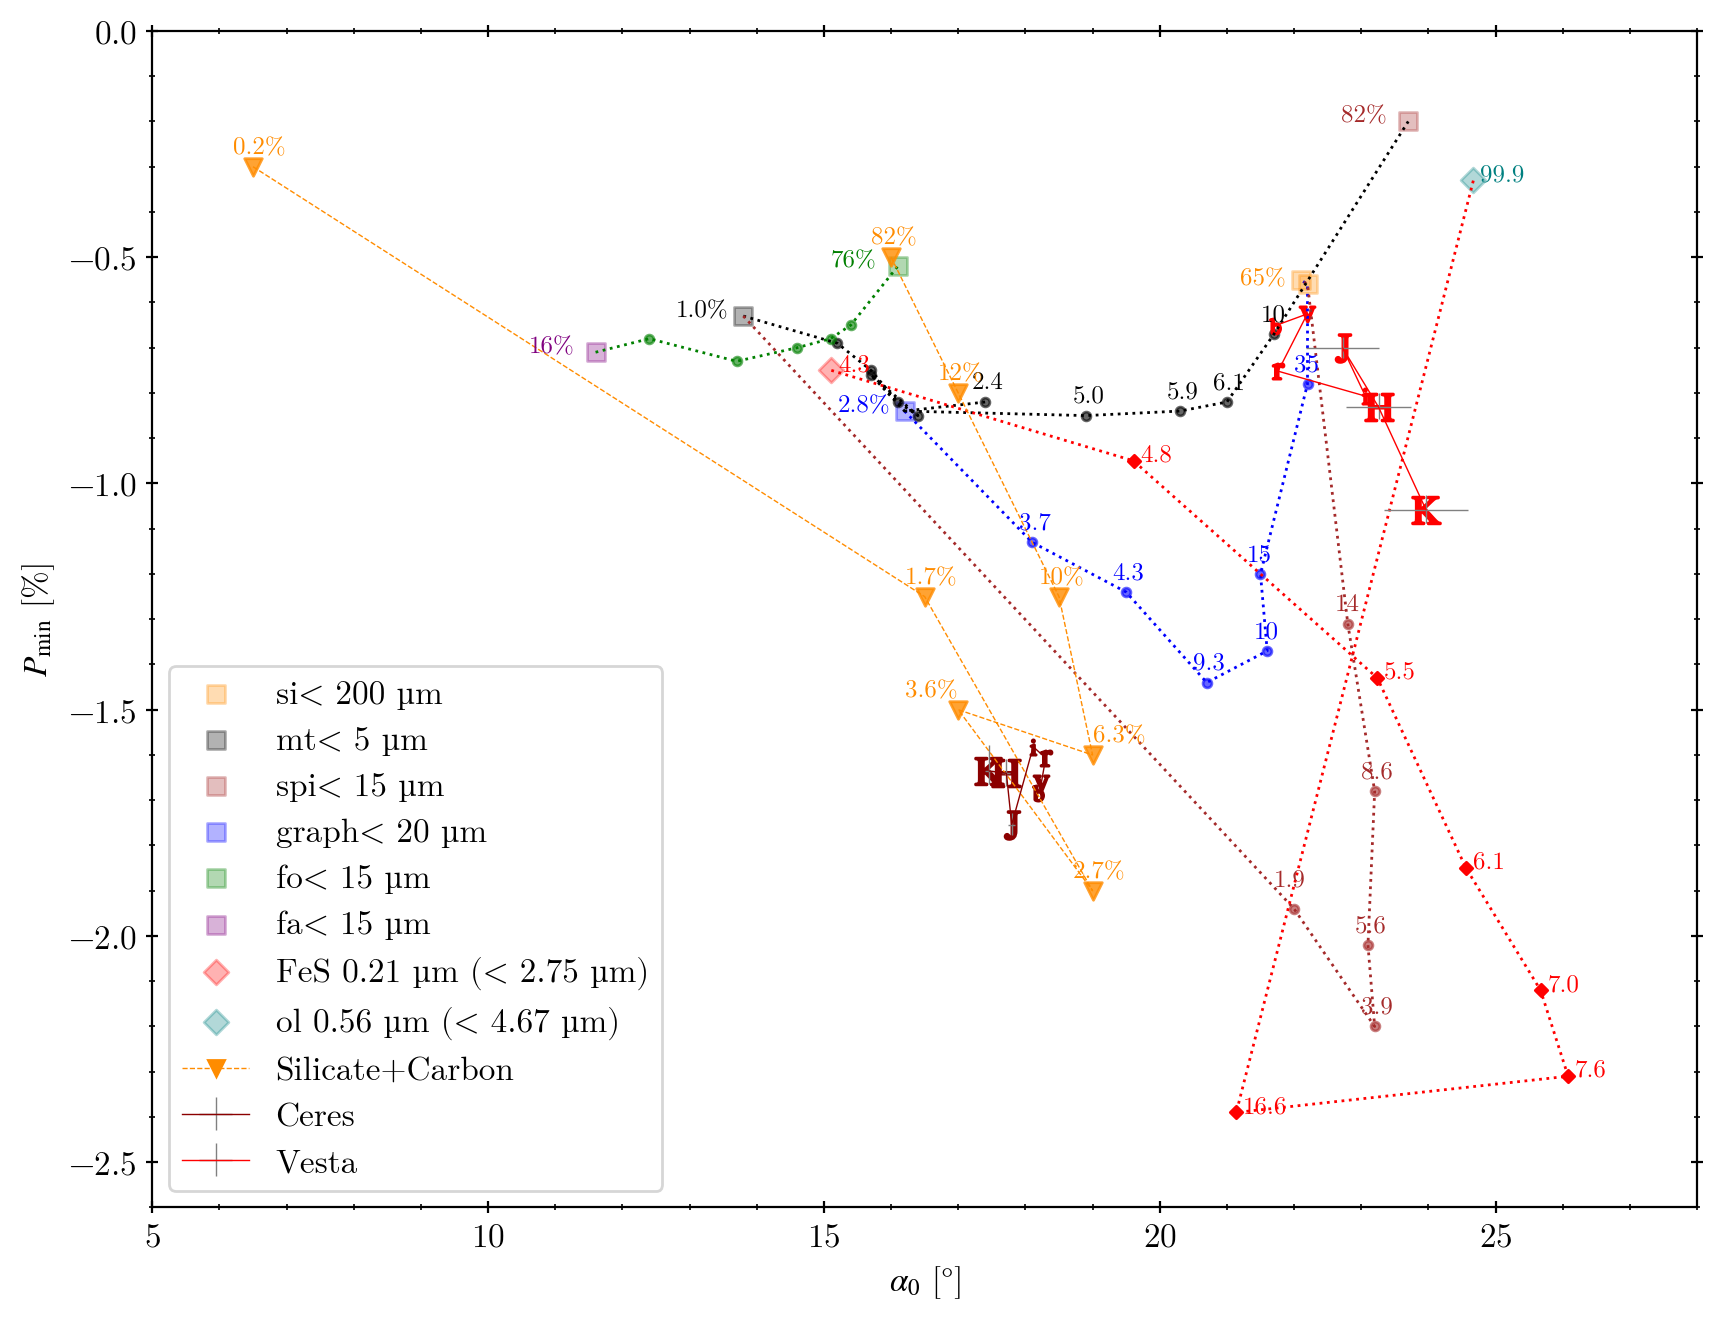

In [14]:
kws_shk92lab = {
    'Transparent glass powder': dict(marker="s", color="g", s=10, facecolor="none"),
    'Soot+MgO': dict(marker="D", facecolor="limegreen", s=10, color="limegreen"),
    'Soot+MgO pressed': dict(marker="o", facecolors="none", s=10, color="limegreen", alpha=0.8)
}

kws_lunar = {
    "maria": dict(marker="o", s=30, facecolors="none", alpha=0.6),
    "highland": dict(marker="s",s=30,  facecolors="none", alpha=0.6),
    "mare crater": dict(marker=r"$\oplus$", s=30, linewidths=0.5, alpha=0.6),
    "highland crater": dict(marker=r"$\boxplus$", s=30, facecolors="none", linewidths=0.5, alpha=0.6),
}

kws_spa22_end = {
    "si":dict(marker="s", s=40, alpha=0.3, color="darkorange", label="si< 200 µm"),
    "mt":dict(marker="s", s=40, alpha=0.3, color="k", label="mt< 5 µm"),
    "spi":dict(marker="s", s=40, alpha=0.3, color="brown", label="spi< 15 µm"),
    "graph":dict(marker="s", s=40, alpha=0.3, color="b", label="graph< 20 µm"),
    "fo":dict(marker="s", s=40, alpha=0.3, color="g", label="fo< 15 µm"),
    "fa":dict(marker="s", s=40, alpha=0.3, color="purple", label="fa< 15 µm"),
}

kws_spa22_mix = {
    "mt-graph":dict(marker="o", s=10, alpha=0.6, color="k"),
    "si-graph":dict(marker="o", s=10, alpha=0.6, color="b"),
    "si-mt":dict(marker="o", s=10, alpha=0.6, color="brown"),
    "spi-graph":dict(marker="o", s=10, alpha=0.6, color="k"),
#     "si-mt-graph":dict(marker="x", s=20, alpha=0.6, color="r"),
#     "fo-graph":dict(marker="^", s=20, alpha=0.6, color="k"),
    "fo-fa":dict(marker="o", s=10, alpha=0.6, color="g"),
#     "fo-spi":dict(marker="^", s=20, alpha=0.6, color="k"),
#     "si-fo":dict(marker="^", s=20, alpha=0.6, color="k"),
#     "si-fo-graph":dict(marker="^", s=20, alpha=0.6, color="k"),
}

df_alum_pure = df_alum_all.loc[df_alum_all["material"]=="Al2O3"].copy()

fig, axs = plt.subplots(1, 1, figsize=(8.5,6.5), sharex=False, sharey=True, gridspec_kw=None)

ax1 = axs

# Spadaccia+2022 ENDMEMBERS
for typ, _kw in kws_spa22_end.items():
    _df = df_lab.loc[(df_lab["sample"] == typ) & (df_lab["ref"]=="2022A&A...665A..49S")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    ax1.scatter(_df["a0"], _df["Pmin"], **kw)
    for i, _row in _df.iterrows():
        if (_alb := _row["_alb"]) > 0:
            _a = f'{_row["_alb"]*100:.0f}%' if _alb > 0.1 else f'{_alb*100:.1f}%'
            _offx = -1.
            _offy = 0.0
            ax1.text(_row["a0"]+_offx, _row["Pmin"]+_offy, _a, color=kw["color"], fontsize=9)

# Spadaccia+2022 MIX
for typ, _kw in kws_spa22_mix.items():
    _df = df_lab.loc[(df_lab["sample"] == typ) & (df_lab["ref"]=="2022A&A...665A..49S")
                     & (df_lab["category"] != "Silica mix 2000")].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    kw = _kw.copy()
    ax1.scatter([None], [None], **kw)
    for i, _row in _df.iterrows():
        if ((_alb := _row["_alb"]) > 0) and (typ not in ["fo-fa", "mt-graph"]):
            _a = f'{_row["_alb"]*100:.0f}' if _alb > 0.1 else f'{_alb*100:.1f}'
            _offx = -0.3 if _alb == 0.019 else -0.2
            _offy = +0.05 if _alb == 0.019 else +0.03
            ax1.text(_row["a0"]+_offx, _row["Pmin"]+_offy, _a, color=kw["color"], fontsize=9)
        ax1.scatter(_row["a0"], _row["Pmin"], **kw)
    ends = typ.split("-")
    _df_ends = df_lab.loc[(df_lab["sample"].isin(ends)) & (df_lab["ref"]=="2022A&A...665A..49S")].copy()
    _df = pd.concat([_df, _df_ends])
    _df = _df.sort_values("_alb").reset_index(drop=True)
    ax1.plot(_df["a0"], _df["Pmin"], ls=":", lw=1, color=kw["color"])


# Experiments by Sultana+23
df_olfes = (df_lab.loc[df_lab["ref"]=="2023Icar..39515492S"]
            .copy()
            .sort_values("_alb")
            .reset_index(drop=True)
           )
ax1.plot(df_olfes["a0"], df_olfes["Pmin"], ls=":", color="r", lw=1)
for _, row in df_olfes.iterrows():
    marker = "D" if row["sample"] in ["Ol", "FeS"] else "D"
    alpha = 0.3 if row["sample"] in ["Ol", "FeS"] else 1
    label = "ol 0.56 µm (< 4.67 µm)" if row["sample"] == "Ol" else "FeS 0.21 µm (< 2.75 µm)" if row["sample"]=="FeS" else None
    color = "teal" if row["sample"] == "Ol" else "r" if row["sample"]=="FeS" else "r"
    ax1.scatter(row["a0"], row["Pmin"], color=color, marker=marker, alpha=alpha, label=label, s=40 if row["sample"] in ["Ol", "FeS"] else 10)
    ax1.text(row["a0"]+0.1, row["Pmin"], f"{row['alb']*100:.1f}", color=color, fontsize=9)

# Experiments by Geake+1986 and Zellner+1977ab etc
for typ, _kw in kws_lab.items():
    _df = df_lab.loc[df_lab["category"] == typ].copy()
    _df = _df.sort_values("_alb").reset_index(drop=True)
    if typ in ["silica+carbon"]:
        kw = _kw.copy()
        _kw = dict(ls="--", color=kw["color"], mfc=kw.get("facecolors"), lw=0.5)
        ax1.plot(_df["a0"], _df["Pmin"], **_kw, marker="")
        ax1.plot([np.nan], [np.nan], **_kw, marker=kw["marker"], label=kw.pop("label"))
        ax1.scatter(_df["a0"], _df["Pmin"], **kw)
        for i, _row in _df.iterrows():
            if (_alb := _row["_alb"]) > 0:
                _a = f'{_row["_alb"]*100:.0f}%' if _alb > 0.1 else f'{_alb*100:.1f}%'
                _offx = -0.8 if _alb in [0.026, 0.036] else 0 if _alb==0.063 else -0.3
                _offy = 0.03
                ax1.text(_row["a0"]+_offx, _row["Pmin"]+_offy, _a, color=kw["color"], fontsize=9)
#     else:
#         ax2.scatter(_df["a0"], _df["Pmin"], ls="", **kw)

# Ceres and Vesta
for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    ax1.errorbar(_df["a0"], _df["Pmin"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                yerr=(_df["dPmin"], _df["DPmin"]), xerr=_df["da0"], label=objname)

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=100 if row.filt in "JHK" else 30)
    ax1.scatter(row["a0"], row["Pmin"], **mk, **kws[row.object])

ax1.legend(loc=3, fontsize=12)
# ax2.legend(loc=3, fontsize=10, ncol=3)
ax1.set(
    xlabel=r"$\alpha_0$ [°]", ylabel=r"$P_\mathrm{min}$ [%]",
    # xlim=(5, 35), ylim=(-3.3, 0.1)
    xlim=(5, 28), ylim=(-2.6, 0.)
#     xlim=(10, 25), ylim=(-2.5, 0.)
)
# ax2.set(
#     xlabel=r"$\alpha_0$ [°]", ylabel=r"$P_\mathrm{min}$ [%]", xlim=(5, 35)
# )
plt.tight_layout(pad=0.1)
plt.savefig("figs/pmin-a0-spa22.pdf", dpi=300)
plt.show();

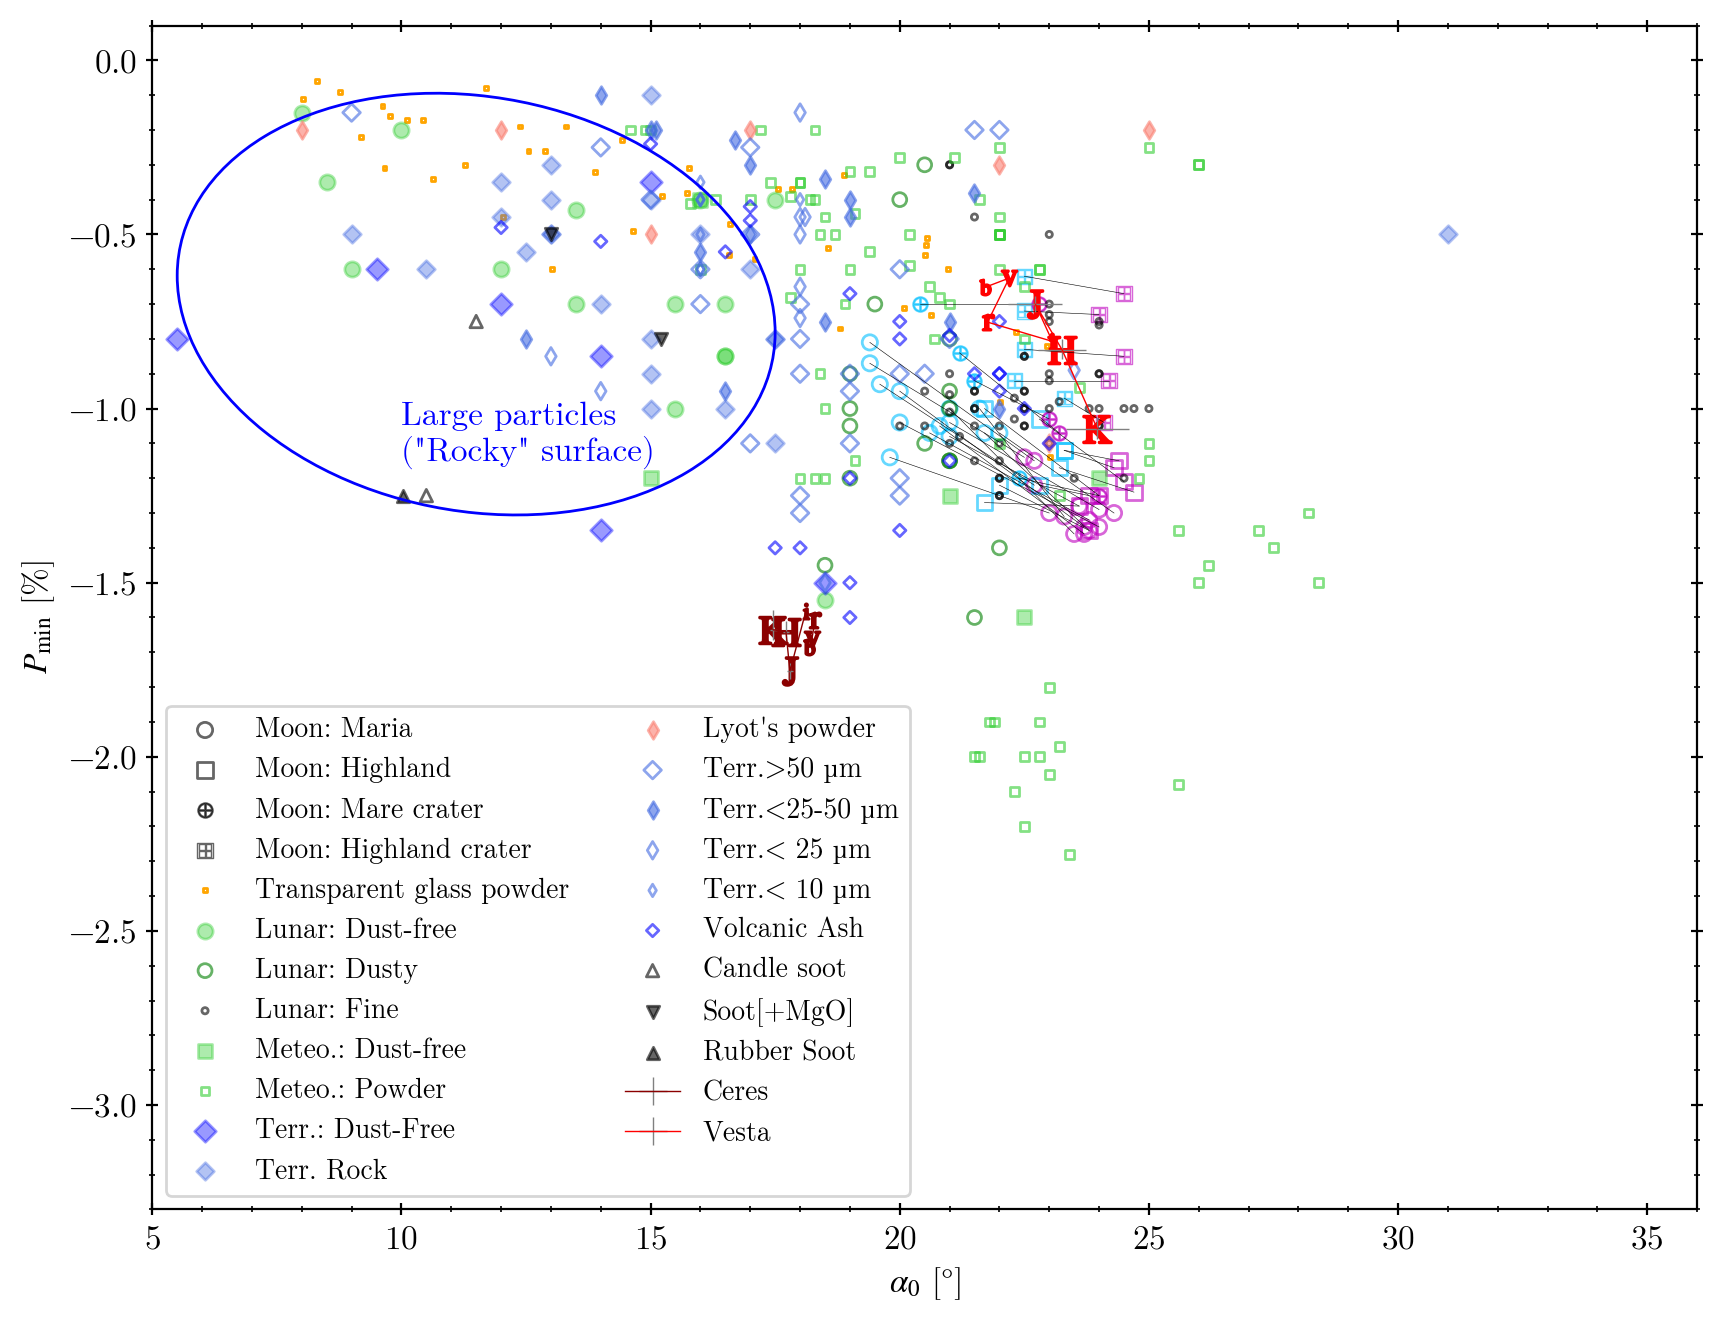

In [15]:
kws_shk92lab = {
    'Transparent glass powder': dict(marker="s", color="orange", facecolor="none", s=2),
}
kws_lunar = {
    "maria": dict(marker="o", s=30, facecolors="none", alpha=0.6),
    "highland": dict(marker="s",s=30,  facecolors="none", alpha=0.6),
    "mare crater": dict(marker=r"$\oplus$", s=30, linewidths=0.5, alpha=0.6),
    "highland crater": dict(marker=r"$\boxplus$", s=30, facecolors="none", linewidths=0.5, alpha=0.6),
}

kws_lab = {
    'Lunar Dust-Free':dict(marker="o", s=30, alpha=0.4, color="limegreen", label="Lunar: Dust-free"),
    'Lunar Dusty':dict(marker="o", facecolors="none", s=25, alpha=0.6, color="g", label="Lunar: Dusty"),
    'Lunar Fine':dict(marker="o", facecolors="none", s=5, alpha=0.6, color="k", label="Lunar: Fine"),
    'Met Dust-Free':dict(marker="s", s=25, alpha=0.4, color="limegreen", label="Meteo.: Dust-free"),
    'Met Powder':dict(marker="s", facecolors="none", s=10, alpha=0.6, color="limegreen", label="Meteo.: Powder"),
    'Rock Dust-Free':dict(marker="D", s=30, alpha=0.4, color="blue", label="Terr.: Dust-Free"),
    'Lyot-rock':dict(marker="D", s=20, alpha=0.4, color="royalblue", label="Terr. Rock"),
    'Lyot-powder':dict(marker="d", s=20, alpha=0.6, color="salmon", label="Lyot's powder"),
    'Rock Powder 340':dict(marker="D", facecolors="none", s=20, alpha=0.6, color="royalblue", label="Terr.>50 µm"),
    'Rock Powder 50':dict(marker="d", s=20, alpha=0.6, color="royalblue", label="Terr.<25-50 µm"),
    'Rock Powder 25':dict(marker="d", facecolors="none", s=20, alpha=0.6, color="royalblue", label="Terr.< 25 µm"),
    'Rock Powder 10':dict(marker="d", facecolors="none", s=10, alpha=0.6, color="royalblue", label="Terr.< 10 µm"),
    'Volcanic Ash':dict(marker="D", facecolors="none", s=10, alpha=0.6, color="blue", label="Volcanic Ash"),
    "Candle Soot":dict(marker="^", facecolors="none", s=20, alpha=0.6, color="k", label="Candle soot"),
    "silica+carbon":dict(marker="v", s=30, alpha=0.8, color="darkorange", label="Silicate+Carbon"),
    # "Silica mix 200":dict(marker="1", s=30, alpha=0.6, color="orange", label="Silica mix 200µm"),
    # "Silica mix 2000":dict(marker="2", s=40, alpha=0.6, color="k", label="Silica mix 2mm"),
    "Soot":dict(marker="v", s=20, alpha=0.6, color="k", label="Soot[+MgO]"),
    "Rubber Soot":dict(marker="^", s=20, alpha=0.6, color="k", label="Rubber Soot"),
}

df_alum_pure = df_alum_all.loc[df_alum_all["material"]=="Al2O3"].copy()

fig, axs = plt.subplots(1, 1, figsize=(8.5,6.5), sharex=False, sharey=True, gridspec_kw=None)

# ax1 = axs[0]
ax2 = axs

# Lunar observation from Shkuratov+1992
for _id in df_lunar.id.unique():
    _rowb = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.42)]
    _rowr = df_lunar.loc[(df_lunar["id"]==_id)&(df_lunar["filter"]==0.65)]
    for aa in [ax2]:
        aa.scatter(_rowb["a0"], -_rowb["P10.5"], **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
        aa.scatter(_rowr["a0"], -_rowr["P10.5"], **kws_lunar[_rowr["type"].iloc[0]], color="m")
        aa.plot((_rowr["a0"], _rowb["a0"]), (-_rowr["P10.5"], -_rowb["P10.5"]), "k-", lw=0.2)
for typ, kw in kws_lunar.items():
    ax2.scatter([np.nan], [np.nan], **kw, color="k", label="Moon: "+typ.capitalize())


# Experiments from Shkuratov+1992
for typ, kw in kws_shk92lab.items():
    _df = df_shk92lab.loc[df_shk92lab["type"]==typ].copy()
    ax2.scatter(_df["a0"], _df["pmin"], **kw, label=typ)
# ax2.annotate("200µm", xy=(8.7, -0.1), xytext=(8.5, 0.02), fontsize=9, color="orange",
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="orange"))
# ax2.annotate("<0.5µm", xy=(22.3, -0.78), xytext=(23.5, -0.5), fontsize=9, color="orange",
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="orange"))
# ax2.annotate("0.5µm", xy=(23, -1.15), xytext=(21.5, -1.3), fontsize=9, color="orange",
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="orange"))

# Alumina from Geake+1990
# for i, row in df_alum_all.iterrows():
#     yoff = 0.0 if i==0 else -0.03
#     fmt = "{:.2f}" if row["size_lambda"] < 1  else "{:.1f}" if row["size_lambda"] < 10 else "{:.0f}"
#     ax1.text(row["a0"]+.2, row["Pmin"] + yoff, fmt.format(row["size_lambda"]), fontsize=9)

# ax1.plot(df_alum_pure["a0"], df_alum_pure["Pmin"], "ko-", alpha=0.3, lw=0.4, label="Alumina")

# for size_lam in df_alum_all.size_lambda.unique():
#     _df = df_alum_all.loc[df_alum_all["size_lambda"] == size_lam]
#     if len(_df) > 1:
#         for _, _row in _df.iterrows():
#             ax1.text(_row["a0"]-1.2, _row["Pmin"]-0.02, f'{_row["albedo"]:.0f}%', color="r", fontsize=9)
#         ax1.plot(_df["a0"], _df["Pmin"], "ko--", alpha=0.8, lw=0.5)
# # ax.plot(df_alum["a0"], df_alum["Pmin"], marker="", color="gray", lw=1)

# Experiments by Geake+1986 and Zellner+1977ab etc
for typ, kw in kws_lab.items():
    _df = df_lab.loc[df_lab["category"] == typ].copy()
    _df = _df.sort_values("A5")
    if typ in ["misc", "silica+carbon"]:
#         if typ in ["silica+carbon"]:
#             ax1.plot(_df["a0"], _df["Pmin"], "k:", lw=0.5)
#             ax1.plot([None], [None], ls=":", color=kw["color"], lw=0.5, label=kw.pop("label"), marker=kw["marker"])
#             ax1.scatter(_df["a0"], _df["Pmin"], ls="", **kw)
#         else:
#             ax1.scatter(_df["a0"], _df["Pmin"], ls="", **kw)
#         for _, _row in _df.iterrows():
#             if _row["A5"] > 0:
#                 _a = f'{_row["A5"]*100:.0f}%' if _row["A5"] > 0.01 else f'{_row["A5"]*100:.1f}%'
#                 ax1.text(_row["a0"]-1.2, _row["Pmin"]-0.02, _a, color=kw["color"], fontsize=9)
        continue
    else:
        ax2.scatter(_df["a0"], _df["Pmin"], **kw)


# for _, row in ast_pva0.iterrows():
#     ax2.errorbar(row.a0, row.Pmin, xerr=row.da0, yerr=row.dPmin, elinewidth=0.5, ecolor="gray",
#                   marker=r"${}$".format(row.type), color="r")

# Ceres and Vesta
for objname in ["Ceres", "Vesta"]:
    _df = df_fit_all.loc[df_fit_all["object"] == objname]
    ax2.errorbar(_df["a0"], _df["Pmin"], lw=0.5, **kws[objname], ecolor="gray", elinewidth=0.5,
                yerr=(_df["dPmin"], _df["DPmin"]), xerr=_df["da0"], label=objname)

for _, row in df_fit_all.iterrows():
    mk = dict(marker=WLEN_MK[row.filt], s=100 if row.filt in "JHK" else 30)
    ax2.scatter(row["a0"], row["Pmin"], **mk, **kws[row.object])


_rock = mpatches.Ellipse(xy=(11.5, -0.7), width=12, height=1.2, angle=-np.pi/4, facecolor="none", edgecolor="b")
ax2.add_artist(_rock)
ax2.text(10, -1.15, "Large particles\n(\"Rocky\" surface)", fontdict=dict(color="b"))

# ax1.legend(loc=3, fontsize=10)
ax2.legend(loc="lower left", fontsize=10, ncol=2)
# ax1.set(
#     xlabel=r"$\alpha_0$ [°]", ylabel=r"$P_\mathrm{min}$ [%]", xlim=(5, 35)
# )
ax2.set(
    xlabel=r"$\alpha_0$ [°]", ylabel=r"$P_\mathrm{min}$ [%]", xlim=(5, 36), ylim=(-3.3, 0.1)
#     , xlim=(13, 36), ylim=(-2.5, 0.1)
)
plt.tight_layout(pad=0.1)
plt.savefig("figs/pmin-a0-sample.pdf", dpi=300)
plt.show();

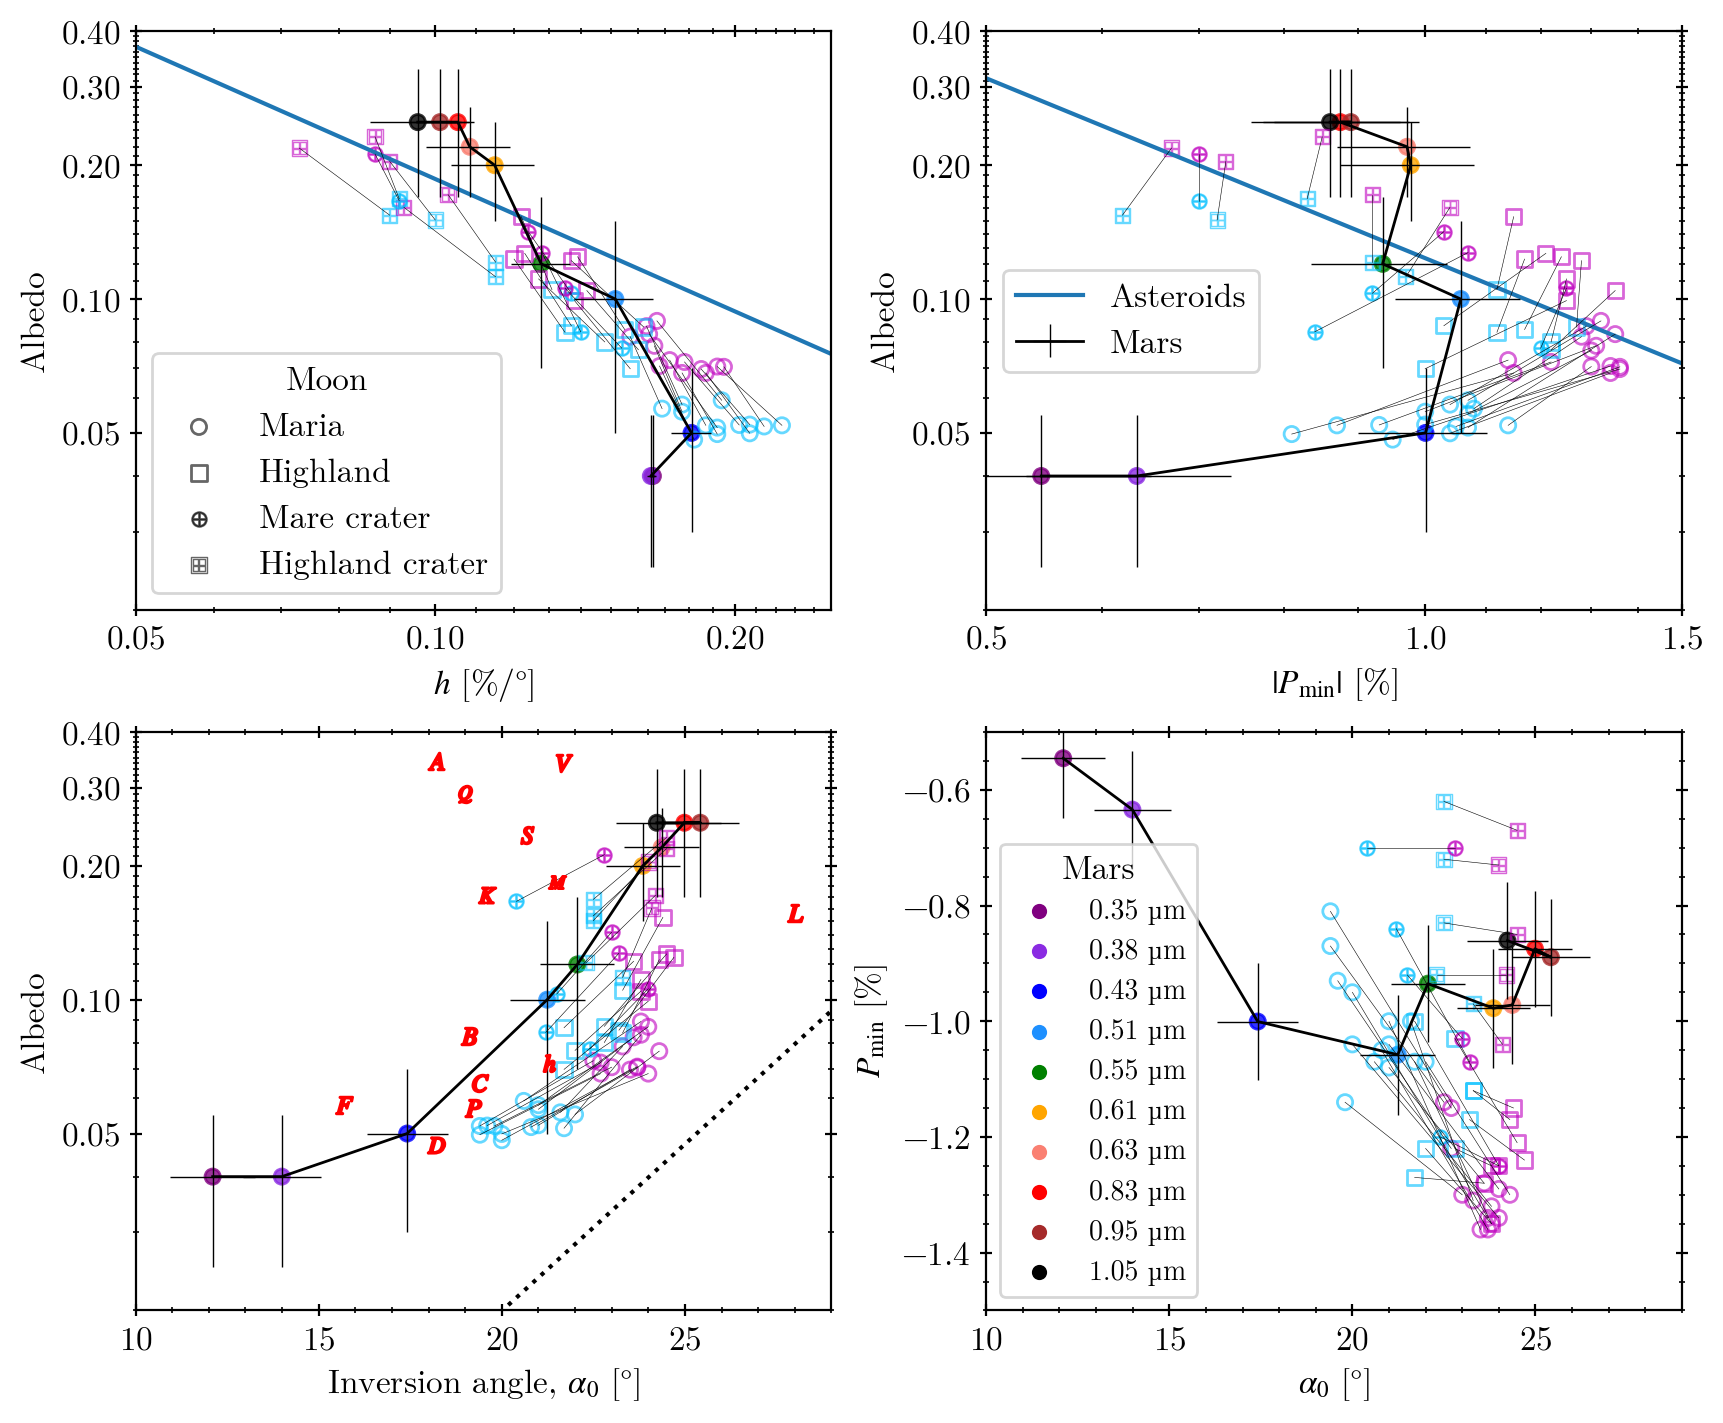

In [19]:
fig = plt.figure(figsize=(8.5, 7), layout="constrained")

gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0., hspace=0.)
axah = fig.add_subplot(gs[0, 0])
axap = fig.add_subplot(gs[0, 1])
axaa = fig.add_subplot(gs[1, 0])
axpa = fig.add_subplot(gs[1, 1])

axmoon = axah.twinx()
axmoon.axis("off")

axap.plot(_pmins, _a_pmins, label="Asteroids")
axah.plot(_hvals, _a_hvals)
colors = ["purple", "blueviolet", "blue", "dodgerblue", "g", "orange", "salmon", "red", "brown", "k"]
kw_err = dict(lw=1, capsize=0, elinewidth=0.5, color="k")

axah.errorbar(df_mars["h"], df_mars["refl"], yerr=df_mars["drefl"], xerr=df_mars["dh"], **kw_err)
axah.scatter(df_mars["h"], df_mars["refl"], c=colors, s=30, alpha=0.8)
axap.errorbar(np.abs(df_mars["pmin"]), df_mars["refl"], yerr=df_mars["drefl"], xerr=df_mars["dpmin"],
              **kw_err, label="Mars")
axap.scatter(np.abs(df_mars["pmin"]), df_mars["refl"], c=colors, s=30, alpha=0.8)
axaa.errorbar(df_mars["a0"], df_mars["refl"], yerr=df_mars["drefl"], xerr=df_mars["da0"], **kw_err)
axaa.scatter(df_mars["a0"], df_mars["refl"], c=colors, s=30, alpha=0.8)
axpa.errorbar(df_mars["a0"], df_mars["pmin"], yerr=df_mars["dpmin"], xerr=df_mars["da0"], **kw_err)
axpa.scatter(df_mars["a0"], df_mars["pmin"], c=colors, s=30, alpha=0.8)
for _c, _w in zip(colors, df_mars["wlen"].tolist()):
    axpa.scatter(np.nan, np.nan, c=_c, label=f"{_w:.2f} µm", s=20)

# Lunar observation from Shkuratov+1992
for _id in df_lunar.id.unique():
    _rowb = df_lunar.loc[(df_lunar["id"] == _id) & (df_lunar["filter"] == 0.42)]
    _rowr = df_lunar.loc[(df_lunar["id"] == _id) & (df_lunar["filter"] == 0.65)]
    axah.scatter(_rowb["h"], _rowb["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
    axah.scatter(_rowr["h"], _rowr["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="m")
    axah.plot((_rowr["h"], _rowb["h"]), (_rowr["alb3.1"]/100, _rowb["alb3.1"]/100), "k-", lw=0.2)
    axap.scatter(_rowb["P10.5"], _rowb["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
    axap.scatter(_rowr["P10.5"], _rowr["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="m")
    axap.plot((_rowr["P10.5"], _rowb["P10.5"]), (_rowr["alb3.1"]/100, _rowb["alb3.1"]/100), "k-", lw=0.2)
    axaa.scatter(_rowb["a0"], _rowb["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
    axaa.scatter(_rowr["a0"], _rowr["alb3.1"]/100, **kws_lunar[_rowb["type"].iloc[0]], color="m")
    axaa.plot((_rowr["a0"], _rowb["a0"]), (_rowr["alb3.1"]/100, _rowb["alb3.1"]/100), "k-", lw=0.2)
    axpa.scatter(_rowb["a0"], -_rowb["P10.5"], **kws_lunar[_rowb["type"].iloc[0]], color="deepskyblue")
    axpa.scatter(_rowr["a0"], -_rowr["P10.5"], **kws_lunar[_rowr["type"].iloc[0]], color="m")
    axpa.plot((_rowr["a0"], _rowb["a0"]), (-_rowr["P10.5"], -_rowb["P10.5"]), "k-", lw=0.2)

for typ, kw in kws_lunar.items():
    axmoon.scatter(np.nan, np.nan, **kw, color="k", label=typ.capitalize())


# Asteroids in albedo-a0
aa0 = np.arange(5, 35)
axaa.plot(aa0, 10**(0.075*aa0 - 3.2), "k:")
for _, row in ast_pva0.iterrows():
    axaa.errorbar(row.a0, row.pv, elinewidth=0.5, ecolor="gray",
                  marker=r"${}$".format(row.type), color="r")

# Set
axah.set(xlabel="$h$ [%/°]", ylabel="Albedo",
         yscale='log', xscale='log', xlim=(0.05, 0.25), ylim=(0.02, 0.4))
axap.set(xlabel="$|P_\mathrm{min}|$ [%]",
         ylabel="Albedo",
         yscale='log', xscale='log', xlim=(0.5, 1.5), ylim=(0.02, 0.4))
axaa.set(ylabel="Albedo", xlabel="Inversion angle, $α_0$ [°]",
         yscale='log',
         xlim=(10, 29), ylim=(0.02, 0.4)
         )
axpa.set(
    xlabel=r"$\alpha_0$ [°]", ylabel=r"$P_\mathrm{min}$ [%]",
    xlim=(10, 29), ylim=(-1.5, -0.5)
)

# Show some more ticks on x-axis
axah.set_xticks([0.05, 0.1, 0.2])
axah.set_xticks(np.arange(0.05, 0.25, 0.01), labels=[], minor=True)
axap.set_xticks([0.5, 1, 1.5])
axap.set_xticks(np.arange(0.5, 1.5, 0.1), labels=[], minor=True)
axah.xaxis.set_major_formatter(ScalarFormatter())
axap.xaxis.set_major_formatter(ScalarFormatter())

# Albedo:
for _ax in [axah, axap, axaa]:
    _ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.4])
    _ax.set_yticks(np.arange(0.02, 0.4, 0.01), labels=[], minor=True)
    _ax.yaxis.set_major_formatter(ScalarFormatter())

axap.legend(loc=6, fontsize=12)
axmoon.legend(loc=3, fontsize=12, title="Moon")
axpa.legend(loc=3, fontsize=10, title="Mars")

plt.savefig("figs/mars.pdf", dpi=300)
plt.show()